# Trabalho prático Visão por Computador

## Group 13  <br>
Nelson José Marques Martins Almeida pg52697 <br>
Carlos Gustavo Silva Pereira pg53723

## Enunciado do trabalho 1 - grupo (2-3 elementos)
Neste trabalho pretende-se explorar modelos de deep learning aplicados ao dataset GTSRB (dataset alemão de sinais de trânsito) para obter o melhor resultado possível em termos de accuracy no dataset de teste (o melhor resultado publicado é 99.82%). <br>
O trabalho divide-se em duas partes:
Numa primeira parte é suposto treinar modelos aplicando "data augmentation", tanto em pré-processamento como dinâmico. Pretende-se nesta primeira parte explorar os filtros e métodos de processamento de imagem e avaliar o impacto dos mesmos no desempenho final da rede. Parte da avaliação será ditada pelo uso das técnicas de processamento de imagem utilizadas.  Devem ser treinadas vários modelos, com "data augmentation" diferentes, e ser realizada uma análise aos resultados obtidos.
Numa segunda fase é pretendido estudar o potencial de utilizar ensembles de redes. As redes que farão parte do ensemble são as treinadas na primeira fase.
Dataset alemão:
Imagens para treino (ZIP)https://www.di.uminho.pt/~arf/storage/dl/train_images.zip
Imagens para teste (ZIP)https://www.di.uminho.pt/~arf/storage/dl/test_images.zip
Para além do notebook (ou scripts python avulsas) pretende-se um pequeno relatório que descreva as opções tomadas e apresente os testes realizados. O notebook ou as scripts também devem ser devidamente comentadas.

In [ ]:
%pip install torch torchvision torchaudio torchinfo matplotlib numpy tqdm requests pandas seaborn scikit-learn opencv-python

In [1]:

# Lets import the needed dependencies
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision.transforms import v2

import torchinfo

import matplotlib.pyplot as plt
import numpy as np

# importing a module with utilities for displaying stats and data
import sys
import os

from tqdm import tqdm
import requests

# Switch to the path
sys.path.append('./util/')

#Lets import the auxiliary files
import vcpi_util
from vcpi_util import *
from vcpi_util import TransfDataset
from Models import *
from SyntheticDataGeneration import *


DEVICE  = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Available device: {DEVICE}")
print(torch.cuda.is_available())


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available device: cpu
False


In [2]:
# Lets download the needed images if they are not already downloaded
if not os.path.exists(f'data'):
    os.makedirs(f'data')

if not os.path.exists(f"data/train"):
    print("Downloading train images...")
    if "train_images.zip" not in os.listdir("data/"): requests.get("https://www.di.uminho.pt/~arf/storage/dl/train_images.zip")
    print("Unziping train images...")
    os.system(f"unzip data/train_images.zip -d data/")
    #os.system("rm train_images.zip")

if not os.path.exists(f"data/test"):
    print("Downloading test images...")
    if "test_images.zip" not in os.listdir("data/"): requests.get("https://www.di.uminho.pt/~arf/storage/dl/test_images.zip")
    print("Unziping testing images...")
    os.system(f"unzip data/test_images.zip -d data/")
    #os.system("rm test_images.zip")

if not os.path.exists(f"data/German_Templates") and "German_Templates.zip" in os.listdir("data"):
  print("Extractig template images...")
  os.system(f"unzip data/German_Templates.zip -d data/")
  #os.system("rm German_Templates.zip")

if not os.path.exists(f"data/SyntheticData") and "SyntheticData.zip" in os.listdir("data"):
  print("Extractig Synthetic images...")
  os.system(f"unzip data/SyntheticData.zip -d data/")
  #os.system("rm German_Templates.zip")

print("Data downloaded and extracted successfully!")

Data downloaded and extracted successfully!


In [3]:
#Lets define the paths to store the images
PATH_TRAINING_SET = "./data/train/Final_Training/Images/"
PATH_TEST_SET = "./data/test/"
PATH_SYNTHETIC_SET = "./data/SyntheticData/"
PATH_TEMPLATES = "./data/German_Templates/"
PATH_TRAINING_ENHANCED = "./data/train_enhanced/"
PATH_TRAINING_BALANCED = "./data/train_balanced_2000/"

BATCH_SIZE = 64
IMG_SIZE = 32
EPOCHS = 200

---

# Data Augmentation

Para aumentarmos os dados de treino temos o programa auxiliar para gerar dados sintéticos a partir dos templates dos sinais presentes no dataset de treino. 

Estes dados sintéticos são gerados com transformações aleatórias para simular diversas circunstâncias de captura, transformações estas como alterações no contraste, blur, rotações, iluminação e ruído

In [4]:
#Lets generate synthetic data to enhance the training data
# The synthetic data will be generated using templates for the signals in the dataset
syntheticDataGenerator = SyntheticDataGeneration(
    templateImagesPath=PATH_TEMPLATES,
    syntheticDataPath=PATH_SYNTHETIC_SET,
    trainingImagesPath=PATH_TRAINING_SET
    )

syntheticDataGenerator.generate()

Generating 440 images for signal 10_0.png...


100%|██████████| 440/440 [00:08<00:00, 53.14it/s]


Synthetic data for signal 10_1.png already generated, skipping...
Generating 350 images for signal 12_1.png...


100%|██████████| 350/350 [00:03<00:00, 95.58it/s]


Generating 1040 images for signal 8.png...


100%|██████████| 1040/1040 [00:19<00:00, 53.70it/s]


Generating 980 images for signal 9.png...


100%|██████████| 980/980 [00:19<00:00, 50.75it/s]


Synthetic data for signal 12_0.png already generated, skipping...
Generating 1670 images for signal 14.png...


100%|██████████| 1670/1670 [00:31<00:00, 52.68it/s]


Generating 1910 images for signal 28.png...


100%|██████████| 1910/1910 [00:34<00:00, 55.53it/s]


Generating 2180 images for signal 29.png...


100%|██████████| 2180/2180 [00:39<00:00, 55.44it/s]


Generating 1820 images for signal 15.png...


100%|██████████| 1820/1820 [00:33<00:00, 54.24it/s]


Generating 1340 images for signal 17.png...


100%|██████████| 1340/1340 [00:24<00:00, 54.24it/s]


Generating 2030 images for signal 16.png...


100%|██████████| 2030/2030 [00:37<00:00, 54.09it/s]


Generating 290 images for signal 13.png...


100%|██████████| 290/290 [00:05<00:00, 55.93it/s]


Generating 2150 images for signal 39.png...


100%|██████████| 2150/2150 [00:39<00:00, 54.42it/s]


Generating 1130 images for signal 11.png...


100%|██████████| 1130/1130 [00:20<00:00, 56.13it/s]


Generating 1250 images for signal 35_1.png...


100%|██████████| 1250/1250 [00:23<00:00, 54.07it/s]


Synthetic data for signal 35_0.png already generated, skipping...
Generating 2120 images for signal 21.png...


100%|██████████| 2120/2120 [00:38<00:00, 55.64it/s]


Generating 2090 images for signal 20.png...


100%|██████████| 2090/2090 [00:37<00:00, 55.46it/s]


Generating 2030 images for signal 34.png...


100%|██████████| 2030/2030 [00:39<00:00, 51.41it/s]


Generating 2060 images for signal 22.png...


100%|██████████| 2060/2060 [00:36<00:00, 56.27it/s]


Generating 2060 images for signal 36.png...


100%|██████████| 2060/2060 [00:38<00:00, 53.82it/s]


Generating 2240 images for signal 37.png...


100%|██████████| 2240/2240 [00:41<00:00, 53.83it/s]


Generating 1940 images for signal 23.png...


100%|██████████| 1940/1940 [00:37<00:00, 51.09it/s]


Generating 2210 images for signal 27.png...


100%|██████████| 2210/2210 [00:42<00:00, 51.84it/s]


Generating 1761 images for signal 33.png...


100%|██████████| 1761/1761 [00:34<00:00, 50.69it/s]


Generating 2210 images for signal 32.png...


100%|██████████| 2210/2210 [00:40<00:00, 54.55it/s]


Generating 1850 images for signal 26.png...


100%|██████████| 1850/1850 [00:34<00:00, 53.45it/s]


Generating 1250 images for signal 18.png...


100%|██████████| 1250/1250 [00:22<00:00, 54.52it/s]


Generating 2000 images for signal 30.png...


100%|██████████| 2000/2000 [00:36<00:00, 55.54it/s]


Generating 2180 images for signal 24.png...


100%|██████████| 2180/2180 [00:47<00:00, 46.33it/s]


Generating 1670 images for signal 31.png...


100%|██████████| 1670/1670 [00:33<00:00, 50.37it/s]


Generating 2240 images for signal 19.png...


100%|██████████| 2240/2240 [00:41<00:00, 53.72it/s]


Generating 470 images for signal 4.png...


100%|██████████| 470/470 [00:09<00:00, 50.08it/s]


Generating 2210 images for signal 42.png...


100%|██████████| 2210/2210 [00:42<00:00, 52.44it/s]


Generating 590 images for signal 5.png...


100%|██████████| 590/590 [00:11<00:00, 50.64it/s]


Generating 380 images for signal 38_2.png...


100%|██████████| 380/380 [00:07<00:00, 52.73it/s]


Synthetic data for signal 38_0.png already generated, skipping...
Generating 2210 images for signal 41.png...


100%|██████████| 2210/2210 [00:40<00:00, 54.59it/s]


Generating 1010 images for signal 7.png...


100%|██████████| 1010/1010 [00:18<00:00, 54.01it/s]


Generating 2090 images for signal 40_0.png...


100%|██████████| 2090/2090 [00:39<00:00, 53.08it/s]


Synthetic data for signal 40_1.png already generated, skipping...
Generating 2030 images for signal 6.png...


100%|██████████| 2030/2030 [00:37<00:00, 54.57it/s]


Synthetic data for signal 38_1.png already generated, skipping...
Generating 200 images for signal 2.png...


100%|██████████| 200/200 [00:03<00:00, 54.32it/s]


Generating 950 images for signal 25_0.png...


100%|██████████| 950/950 [00:17<00:00, 55.49it/s]


Synthetic data for signal 25_1.png already generated, skipping...
Generating 1040 images for signal 3.png...


100%|██████████| 1040/1040 [00:19<00:00, 53.88it/s]


Generating 230 images for signal 1.png...


100%|██████████| 230/230 [00:04<00:00, 51.88it/s]


Generating 2240 images for signal 0.png...


100%|██████████| 2240/2240 [00:43<00:00, 51.45it/s]


Synthetic data generation finished!
Synthetic data for signal 10_0.png already generated, skipping...
Synthetic data for signal 10_1.png already generated, skipping...
Synthetic data for signal 12_1.png already generated, skipping...
Synthetic data for signal 8.png already generated, skipping...
Synthetic data for signal 9.png already generated, skipping...
Synthetic data for signal 12_0.png already generated, skipping...
Synthetic data for signal 14.png already generated, skipping...
Synthetic data for signal 28.png already generated, skipping...
Synthetic data for signal 29.png already generated, skipping...
Synthetic data for signal 15.png already generated, skipping...
Synthetic data for signal 17.png already generated, skipping...
Synthetic data for signal 16.png already generated, skipping...
Synthetic data for signal 13.png already generated, skipping...
Synthetic data for signal 39.png already generated, skipping...
Synthetic data for signal 11.png already generated, skipping..

Vamos balancear o dataset de treino com os dados gerados de forma sintética

Para isso vamos criar um dataset adicional de forma a unir as imagens de treino com as geradas sintéticamente

In [7]:
#Lets balance the dataset
if "train_enhanced" not in os.listdir("data/"):
    os.mkdir(PATH_TRAINING_ENHANCED)
    print("Balancing the training set...")
    for path in os.listdir(PATH_TRAINING_SET):
        # Lets merge the training and synthetic data
        if path == ".DS_Store": continue
        os.mkdir(f"./data/train_enhanced/{path}")
        for image in os.listdir(f"{PATH_TRAINING_SET}{path}"):
            if not image.endswith(".ppm"): continue
            img = cv2.imread(f"{PATH_TRAINING_SET}/{path}/{image}")
            cv2.imwrite(f"{PATH_TRAINING_ENHANCED}{path}/{image}", img)
        for image in os.listdir(f"{PATH_SYNTHETIC_SET}{path}"):
            img_name = image
            if image in os.listdir(f"{PATH_SYNTHETIC_SET}/{path}"): 
                img_name = img_name.split(".")[0] + "_synthetic." + img_name.split(".")[1]
            img = cv2.imread(f"{PATH_SYNTHETIC_SET}{path}/{image}")

            cv2.imwrite(f"{PATH_TRAINING_ENHANCED}{path}/{img_name}", img)
            
    print("Data balanced successfully!")

Balancing the training set...
Data balanced successfully!


Vamos optar por outra estratégia de balanceamento, onde para cada conjunto de sinais vamos completar o seu dataset aplicando transformações ao seus dados ao invés de gerar dados adicionais sintéticamente

In [18]:
import random 
from PIL import Image, ImageEnhance

def imagesPerSignal(trainingImagesPath, numImages = 2000):
    
    trainingImagesPath = trainingImagesPath
    trainingImagesPaths = os.listdir(trainingImagesPath)
    
    #Lets get the number of signals to generate
    # For this we will consult the number of images in the training dataset for each signal
    # Then we will get the max number of images and generate the same number of images for each signal + 200 images
    # This is to ensure that we have enough images for each signal
    maxImages = 0
    imagesPerSignal = {}
    for signal in trainingImagesPaths:

        if not os.path.isdir(f"{trainingImagesPath}/{signal}"):
            continue

        images = os.listdir(f"{trainingImagesPath}/{signal}")

        imagesPerSignal[signal] = len(images)
        
        if len(images) > maxImages:
            maxImages = len(images)

    for signal in imagesPerSignal.keys():
        #imagesPerSignal[signal] = max(0, abs(imagesPerSignal[signal]-maxImages)) 
        imagesPerSignal[signal] = max(0, numImages-imagesPerSignal[signal])

    return imagesPerSignal

IMAGES_PER_CLASS = 2000

signals = imagesPerSignal(PATH_TRAINING_SET)

classes = os.listdir(f'data/train_balanced_{IMAGES_PER_CLASS}/Final_Training/Images')

list_img = []
for cla in classes:
    if not os.path.isdir(f'data/train_balanced_{IMAGES_PER_CLASS}/Final_Training/Images/{cla}'):
        continue
    list_img = os.listdir(f'data/train_balanced_{IMAGES_PER_CLASS}/Final_Training/Images/{cla}')
    random.shuffle(list_img)
    for k in range(signals[cla]):

        filename = f'data/train_balanced_{IMAGES_PER_CLASS}/Final_Training/Images/{cla}/{list_img[(k - len(list_img)) % len(list_img)]}'
        if not filename.endswith('.ppm'):
            continue
        im = Image.open(filename)

        r = random.uniform(-10.0,10.0)
        im = im.rotate(r)
        r1 = random.uniform(-3.0,3.0)
        r2 = random.uniform(-3.0,3.0)

        im = im.transform(im.size, Image.Transform.AFFINE, (1, 0, r1, 0, 1, r2))

        r = random.uniform(1.0, 1.3)
        im = ImageEnhance.Sharpness(im)
        im = im.enhance(r)

        r = random.uniform(1.0, 1.3)
        im = ImageEnhance.Contrast(im)
        im = im.enhance(r)
        
        im = im.resize((32,32))

        im.save(f'data/train_balanced_{IMAGES_PER_CLASS}/Final_Training/Images/{cla}/{cla}_{k}.ppm')
    print(f"Loaded {cla} with {k} aditional images")
print("Data balanced successfully!")

Loaded 00031 with 1218 aditional images
Loaded 00009 with 528 aditional images
Loaded 00036 with 1608 aditional images
Loaded 00000 with 1788 aditional images
Loaded 00038 with 1788 aditional images
Loaded 00007 with 558 aditional images
Loaded 00039 with 1698 aditional images
Loaded 00006 with 1578 aditional images
Loaded 00001 with 1578 aditional images
Loaded 00008 with 588 aditional images
Loaded 00037 with 1788 aditional images
Loaded 00030 with 1548 aditional images
Loaded 00041 with 1758 aditional images
Loaded 00012 with 1758 aditional images
Loaded 00015 with 1368 aditional images
Loaded 00023 with 1488 aditional images
Loaded 00024 with 1728 aditional images
Loaded 00040 with 1638 aditional images
Loaded 00025 with 498 aditional images
Loaded 00022 with 1608 aditional images
Loaded 00014 with 1218 aditional images
Loaded 00013 with 1218 aditional images
Loaded 00035 with 798 aditional images
Loaded 00032 with 1758 aditional images
Loaded 00004 with 18 aditional images
Loaded 

Antes de nos debruçarmos sobre os testes e as arquiteturas vamos aferir os dados que temos em cada dataset

Distribuição de imagens no dataset de treino original

Counter({2: 2250, 1: 2220, 13: 2160, 12: 2100, 38: 2070, 10: 2010, 4: 1980, 5: 1860, 25: 1500, 9: 1470, 7: 1440, 3: 1410, 8: 1410, 11: 1320, 18: 1200, 35: 1200, 17: 1110, 14: 780, 31: 780, 33: 689, 15: 630, 26: 600, 28: 540, 23: 510, 30: 450, 6: 420, 16: 420, 34: 420, 36: 390, 22: 390, 40: 360, 20: 360, 21: 330, 39: 300, 24: 270, 29: 270, 41: 240, 27: 240, 32: 240, 42: 240, 19: 210, 0: 210, 37: 210})


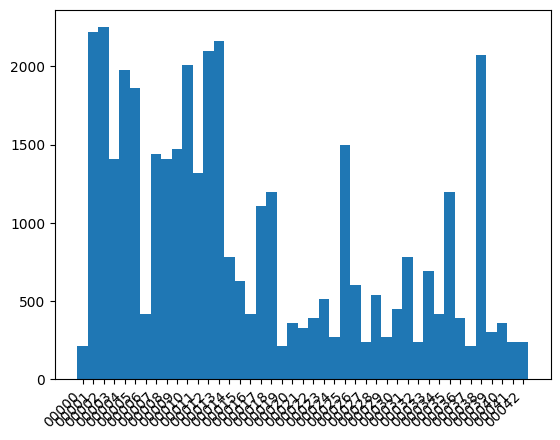

In [9]:
base_transform = v2.Compose([
        v2.ToImage(),
        v2.Resize((IMG_SIZE, IMG_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
])

train_data = torchvision.datasets.ImageFolder(PATH_TRAINING_SET, transform=base_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

target_list = []

for _, targets in train_loader:
    target_list.extend(targets)

vcpi_util.show_histogram(target_list, train_data.classes)

Distribuiçaõ de imagens no dataset de treino balanceado

Counter({2: 2250, 1: 2220, 13: 2160, 12: 2100, 38: 2070, 10: 2010, 9: 1999, 7: 1999, 18: 1999, 8: 1999, 5: 1999, 17: 1999, 4: 1999, 3: 1998, 31: 1998, 11: 1998, 25: 1998, 35: 1998, 33: 1997, 26: 1997, 15: 1997, 14: 1997, 28: 1996, 23: 1996, 16: 1995, 36: 1995, 30: 1995, 6: 1995, 34: 1995, 22: 1995, 20: 1994, 40: 1994, 21: 1994, 29: 1993, 39: 1993, 24: 1993, 32: 1992, 42: 1992, 27: 1991, 0: 1991, 19: 1991, 41: 1991, 37: 1990})


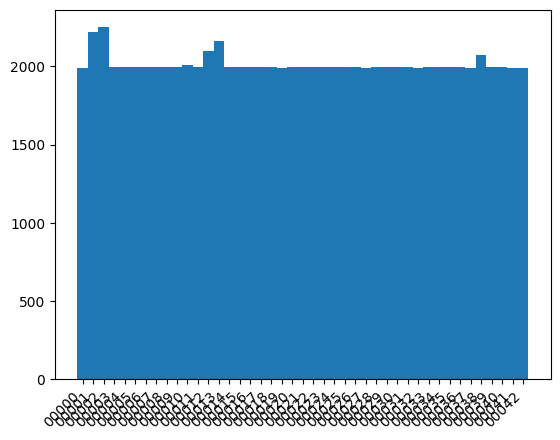

In [19]:
train_data_balanced = torchvision.datasets.ImageFolder("./data/train_balanced_2000/Final_Training/Images/", transform=base_transform)
train_loader_balanced = torch.utils.data.DataLoader(train_data_balanced, batch_size=BATCH_SIZE, shuffle=True)

target_list = []

for _, targets in train_loader_balanced:
    target_list.extend(targets)

vcpi_util.show_histogram(target_list, train_data.classes)

Distribuição de imagens no dataset de treino com data augmentation

Counter({5: 2450, 25: 2450, 14: 2450, 19: 2450, 22: 2450, 30: 2450, 27: 2450, 38: 2450, 2: 2450, 17: 2450, 9: 2450, 3: 2450, 21: 2450, 35: 2450, 31: 2450, 23: 2450, 36: 2450, 41: 2450, 24: 2450, 10: 2450, 11: 2450, 15: 2450, 1: 2450, 13: 2450, 20: 2450, 6: 2450, 33: 2450, 42: 2450, 37: 2450, 16: 2450, 32: 2450, 7: 2450, 4: 2450, 28: 2450, 39: 2450, 18: 2450, 29: 2450, 0: 2450, 26: 2450, 34: 2450, 12: 2450, 8: 2450, 40: 2450})


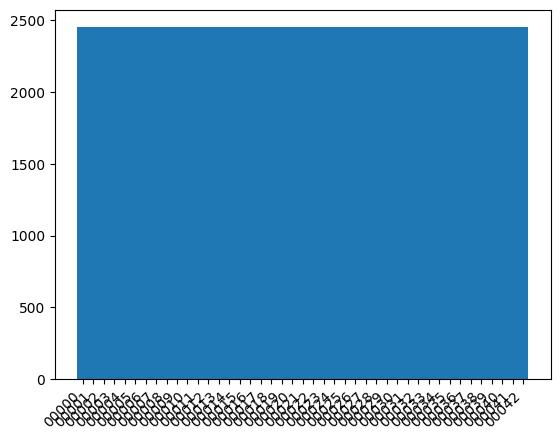

In [11]:
train_data_enhanced = torchvision.datasets.ImageFolder(PATH_TRAINING_ENHANCED, transform=base_transform)
train_loader_enhanced = torch.utils.data.DataLoader(train_data_enhanced, batch_size=BATCH_SIZE, shuffle=True)

target_list = []

for _, targets in train_loader_enhanced:
    target_list.extend(targets)

vcpi_util.show_histogram(target_list, train_data_enhanced.classes)

Distribuição de imagens no dataset de validação

Counter({1: 683, 2: 670, 13: 644, 12: 605, 38: 603, 4: 599, 10: 578, 5: 526, 9: 471, 8: 444, 25: 443, 7: 438, 3: 435, 11: 407, 18: 362, 35: 361, 17: 351, 31: 239, 14: 221, 15: 200, 33: 188, 23: 170, 28: 166, 26: 164, 34: 140, 16: 138, 30: 135, 6: 125, 22: 115, 20: 111, 36: 109, 40: 108, 21: 96, 41: 79, 24: 77, 27: 77, 39: 77, 29: 73, 42: 71, 37: 71, 32: 67, 0: 65, 19: 60})


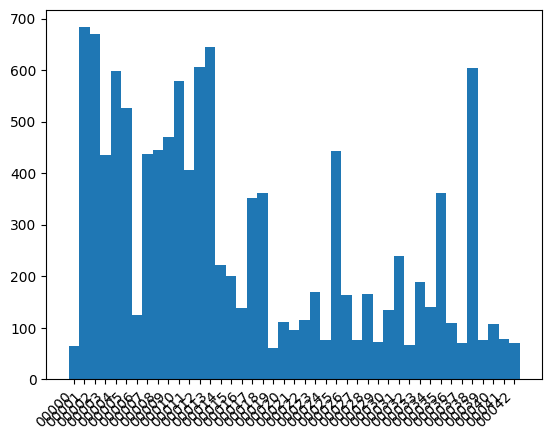

In [12]:
_, val_data = torch.utils.data.random_split(train_data, [0.7,0.3])
val_loader = torch.utils.data.DataLoader(TransfDataset(val_data,base_transform), batch_size=BATCH_SIZE, shuffle=True)

target_list = []

for _, targets in val_loader:
    target_list.extend(targets)

vcpi_util.show_histogram(target_list, train_data.classes)

Distribuição das imagens no dataset de teste

Counter({2: 750, 13: 720, 1: 720, 12: 690, 38: 690, 4: 660, 10: 660, 5: 630, 9: 480, 25: 480, 8: 450, 3: 450, 7: 450, 11: 420, 35: 390, 18: 390, 17: 360, 14: 270, 31: 270, 15: 210, 33: 210, 26: 180, 16: 150, 6: 150, 30: 150, 23: 150, 28: 150, 34: 120, 36: 120, 22: 120, 42: 90, 20: 90, 21: 90, 24: 90, 40: 90, 29: 90, 39: 90, 37: 60, 19: 60, 32: 60, 0: 60, 41: 60, 27: 60})


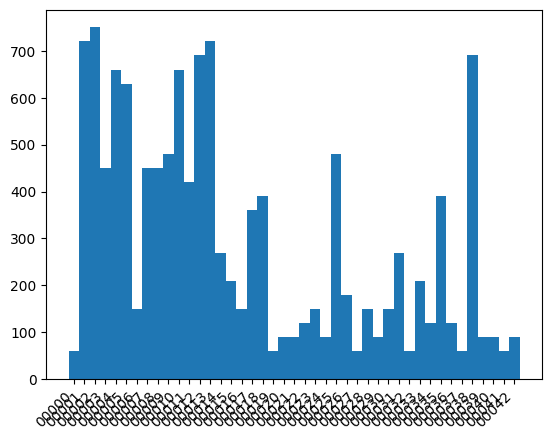

In [13]:
test_data = torchvision.datasets.ImageFolder(PATH_TEST_SET, transform=base_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

target_list = []

for _, targets in test_loader:
    target_list.extend(targets)

vcpi_util.show_histogram(target_list, test_data.classes)

---

# Redes neuronais convolucionais selecionadas:

Para suportar a nossa solução elegemos a seguinte redes neuronal convulocional

In [20]:

class Conv(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)


        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(1200, num_classes)
        

    def forward(self, x):    
        
        # input = (bs, 3, 32, 32)
        x = self.conv1(x) # -> (bs, 16, 30, 30)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x) # -> (bs, 32, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool1(x) # -> (bs, 32, 14, 14)
        
        x = self.conv3(x) # -> (bs, 48, 12, 12)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x) # -> (bs, 48, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool2(x) # -> (bs, 48, 5, 5)
        
        x = torch.flatten(x,1) # -> (bs, 48 * 5 * 5 = 1200)
        x = self.fc1(x)        # -> (bs, num_classes)

        return(x)


---

# Modelo com os dados originais 

Vamos correr um teste inicial que servirá de benchmark onde treinaremos as redes neuronais convolucionais com o dataset de teste e de treino sem nenhuma transformação ou processo de data augmentation aplicado

---

In [21]:
train_data = torchvision.datasets.ImageFolder(PATH_TRAINING_SET, transform=base_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

_, val_data = torch.utils.data.random_split(train_data, [0.7,0.3])
val_loader = torch.utils.data.DataLoader(TransfDataset(val_data,base_transform), batch_size=BATCH_SIZE, shuffle=True)

test_data = torchvision.datasets.ImageFolder(PATH_TEST_SET, transform=base_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [22]:
model_I = Conv(len(train_data.classes)).to(DEVICE)

optimizer = torch.optim.Adam(model_I.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()
early_stopping = Early_Stopping(9)

print(torchinfo.summary(model_I, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE)))

Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     [64, 43]                  --
├─Conv2d: 1-1                            [64, 16, 30, 30]          448
├─BatchNorm2d: 1-2                       [64, 16, 30, 30]          32
├─ReLU: 1-3                              [64, 16, 30, 30]          --
├─Conv2d: 1-4                            [64, 32, 28, 28]          4,640
├─BatchNorm2d: 1-5                       [64, 32, 28, 28]          64
├─ReLU: 1-6                              [64, 32, 28, 28]          --
├─MaxPool2d: 1-7                         [64, 32, 14, 14]          --
├─Conv2d: 1-8                            [64, 48, 12, 12]          13,872
├─BatchNorm2d: 1-9                       [64, 48, 12, 12]          96
├─ReLU: 1-10                             [64, 48, 12, 12]          --
├─Conv2d: 1-11                           [64, 48, 10, 10]          20,784
├─BatchNorm2d: 1-12                      [64, 48, 10, 10]          96
├─R

In [23]:
save_prefix="model_I_noaugmentation"
path_name="model_I_noaugmentation"
if not os.path.exists(f"models/{path_name}"):   
    history_Ihistory_I_noaugmentation = train(DEVICE,
                                    model_I, 
                                    train_loader, 
                                    val_loader, 
                                    EPOCHS, 
                                    loss_fn, 
                                    optimizer, 
                                    scheduler, 
                                    early_stopping, 
                                    save_prefix, 
                                    path_name)
    
model_I.load_state_dict(torch.load(f"models/{path_name}/{save_prefix}_best.pt")["model"])
history_I = torch.load(f"models/{path_name}/{save_prefix}_best.pt")["history"]

In [24]:
#Vamos avaliar o modelo 
best_train = np.asarray(history_I['accuracy']).argmax()
best_val = np.asarray(history_I['val_acc']).argmax()
print(f"Best train accuracy: {history_I['accuracy'][best_train]}")
print(f"Best val accuracy: {history_I['val_acc'][best_val]}")

Best train accuracy: 99.75260925292969
Best val accuracy: 99.77894592285156


In [25]:
eval_I = evaluate(model_I, test_loader, DEVICE)
print(eval_I)

0.967695951461792


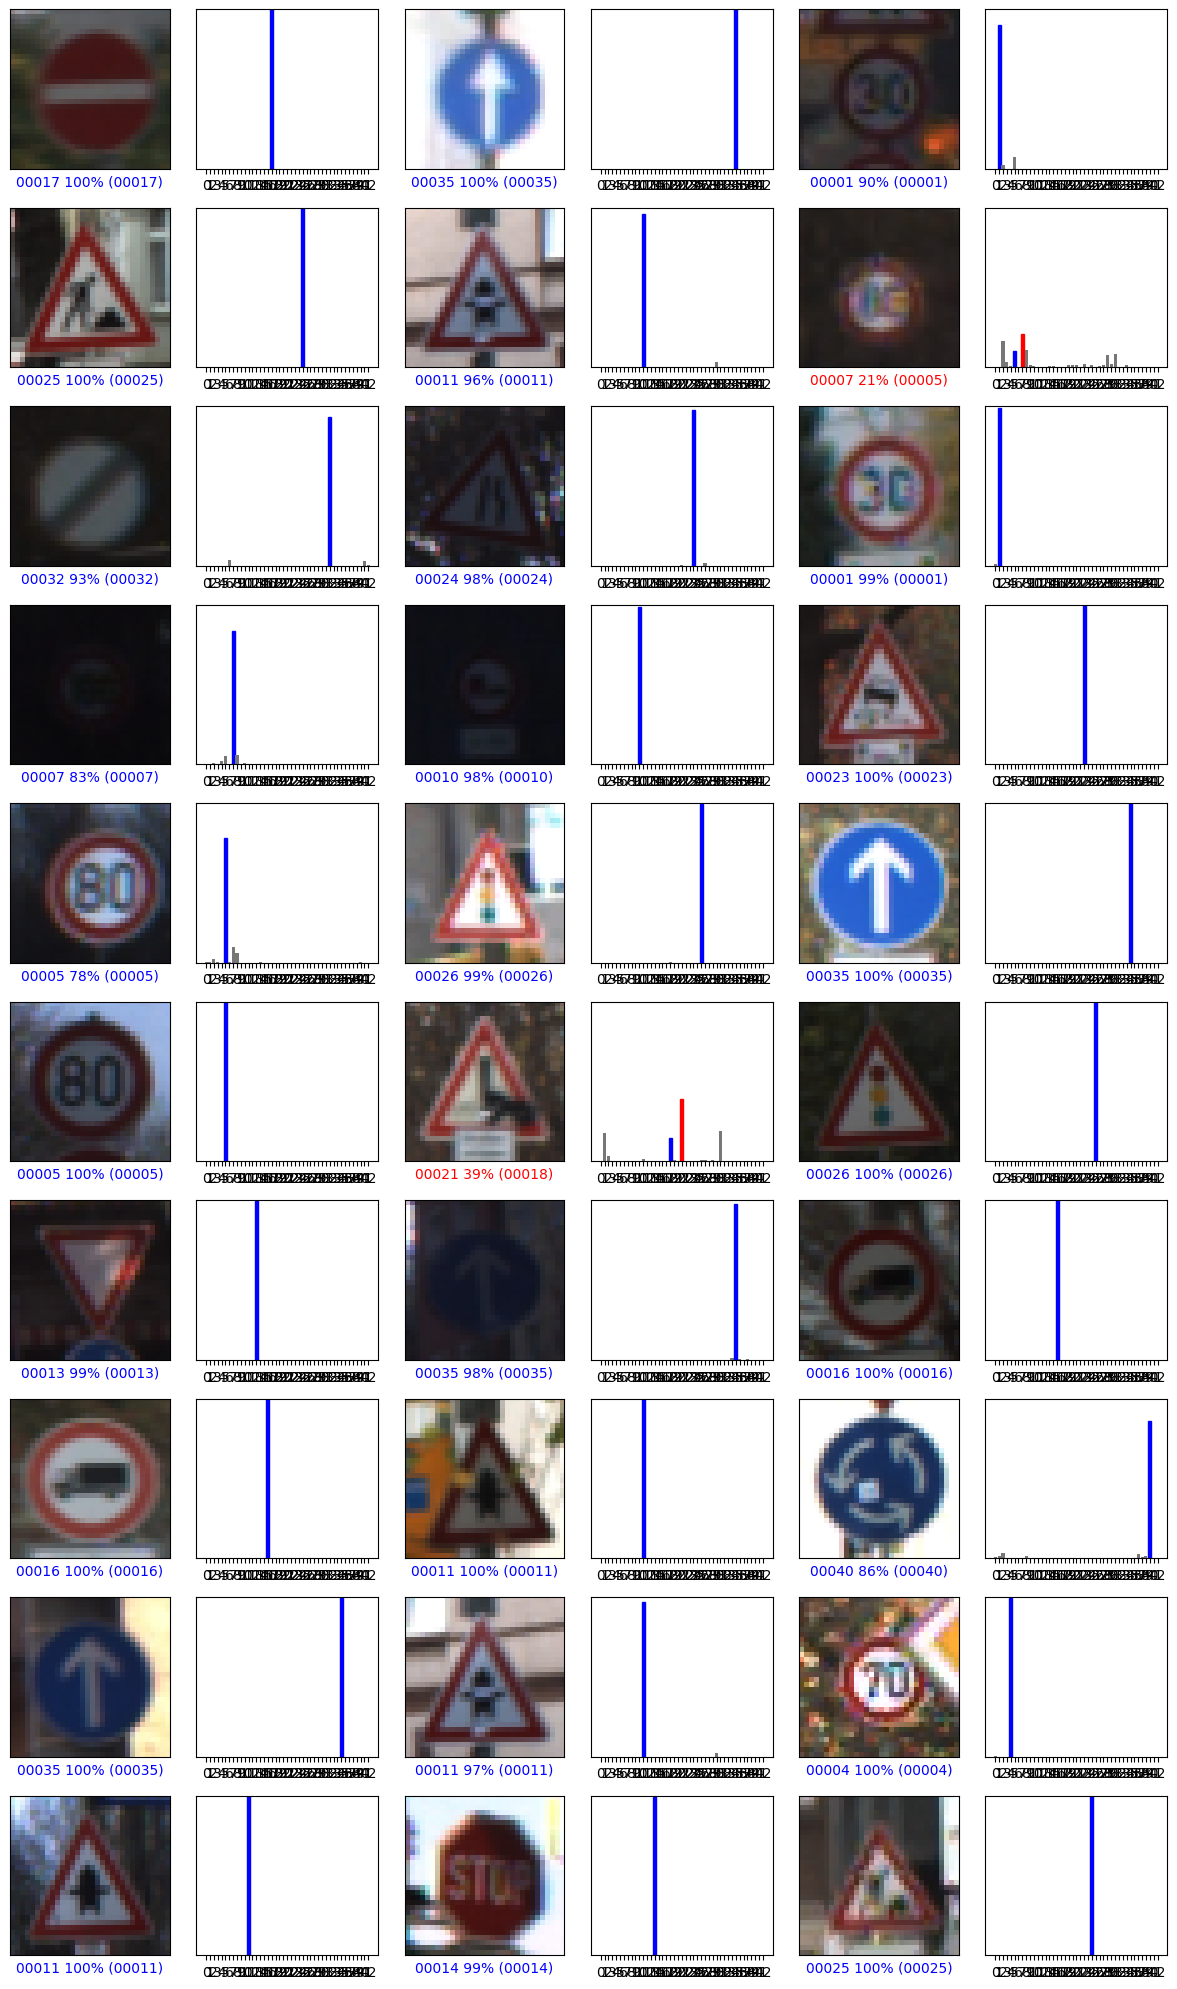

In [26]:
images, targets = next(iter(test_loader))
logits = model_I(images.to(DEVICE))

predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
vcpi_util.plot_predictions(images, predictions, targets, train_data.classes, 10, 3)

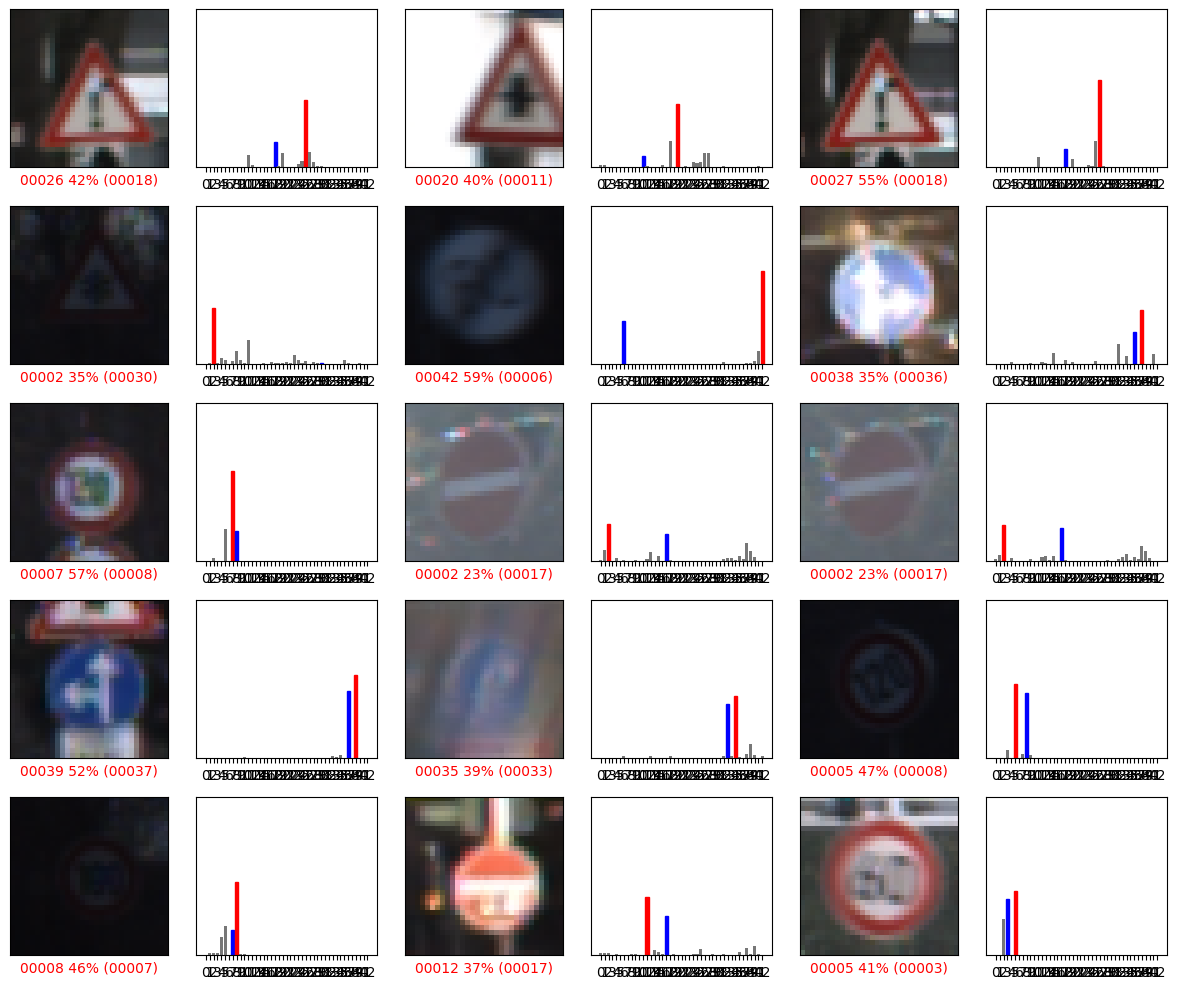

In [29]:
show_bad_preds(model_I, test_loader, train_data.classes, DEVICE, BATCH_SIZE, train_data)

---

# Modelo com os dados originais e transformações 

---

Nestas transformações vamos apenas utilizar rotações e perspetivas bem como uma equalização de histograma visto algumas das imagens no dataset se encontrarem escuras e por isso vamos experimentar com esta abordagem. Não implementamos no entanto transformações como RandomErasing ou Cropping pois experimentaremos mais à frente

In [43]:
transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.2,p=1.0),
        v2.RandomAffine(degrees=3, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
        v2.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2),
        v2.RandomEqualize(p=0.5)
])


test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE, shuffle=True)

rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
train_set, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3])

train_loader = torch.utils.data.DataLoader(TransfDataset(train_set,transform), batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(TransfDataset(val_set,base_transform), batch_size = BATCH_SIZE)

Vamos ver algumas imagens do dataset de treino

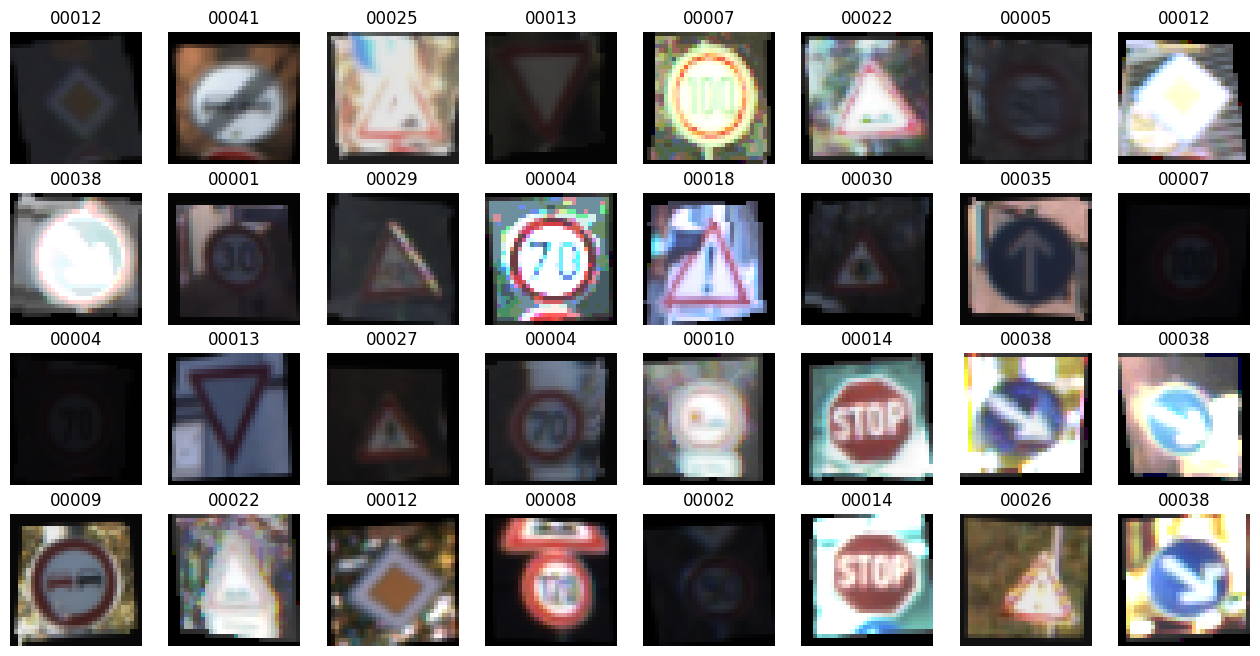

<Figure size 640x480 with 0 Axes>

In [44]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

Vamos ver algumas imagens do dataset de validação

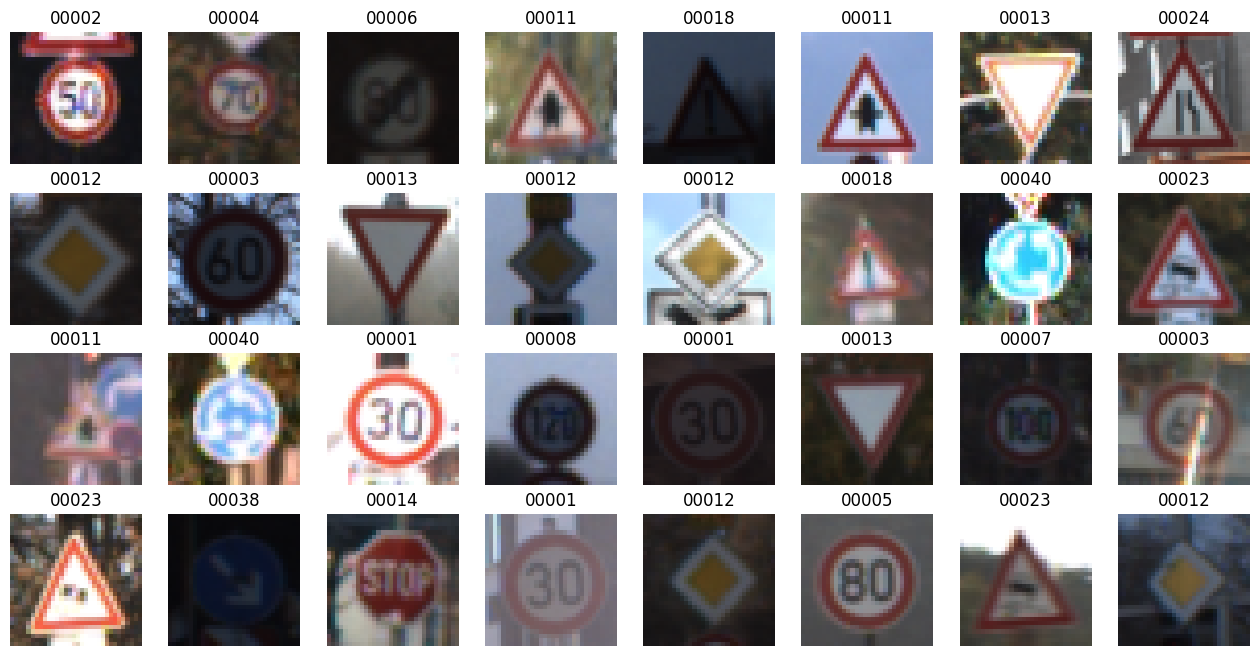

<Figure size 640x480 with 0 Axes>

In [45]:
images, targets = next(iter(val_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

Vamos ver algumas imagens do dataset de teste

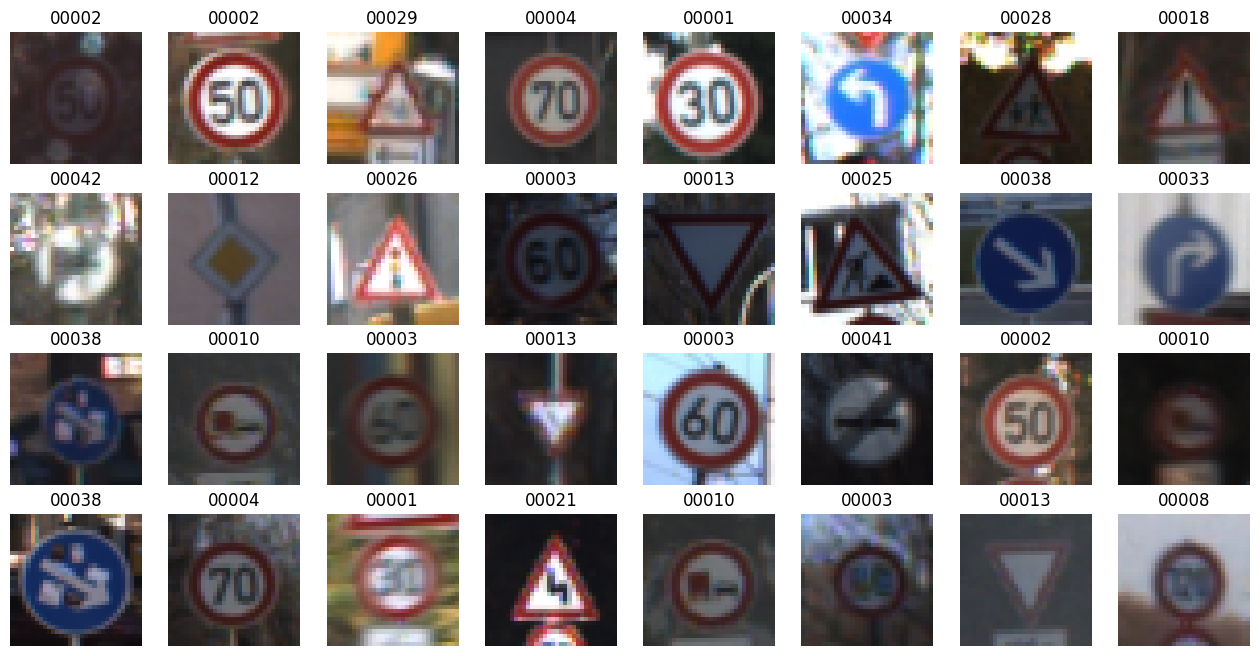

<Figure size 640x480 with 0 Axes>

In [46]:
images, targets = next(iter(test_loader))
vcpi_util.show_images(4,8,images,targets,test_set.classes)

In [34]:
model_I_transforms = Conv(len(rtrain_set.classes))
model_I_transforms.to(DEVICE)

optimizer = torch.optim.Adam(model_I_transforms.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9)

In [35]:
save_prefix="model_I_transforms"
path_name="model_I_transforms"
if not os.path.exists(f"models/{path_name}"):
    history_I_transforms = train(DEVICE,
                                    model_I_transforms, 
                                    train_loader, 
                                    val_loader, 
                                    EPOCHS, 
                                    loss_fn, 
                                    optimizer, 
                                    scheduler, 
                                    early_stopping, 
                                    save_prefix, 
                                    path_name)
    
model_I_transforms.load_state_dict(torch.load(f"models/{path_name}/{save_prefix}_best.pt")["model"])
history_I_transforms = torch.load(f"models/{path_name}/{save_prefix}_best.pt")["history"]

In [36]:
#Vamos avaliar o modelo 
best_train_transforms = np.asarray(history_I_transforms['accuracy']).argmax()
best_val_transforms = np.asarray(history_I_transforms['val_acc']).argmax()
print(f"Best train accuracy: {history_I_transforms['accuracy'][best_train_transforms]}")
print(f"Best val accuracy: {history_I_transforms['val_acc'][best_val_transforms]}")

Best train accuracy: 99.61016082763672
Best val accuracy: 99.9234848022461


In [37]:
eval_I_transforms = evaluate(model_I_transforms, test_loader, DEVICE)
print(eval_I_transforms)

0.9888361096382141


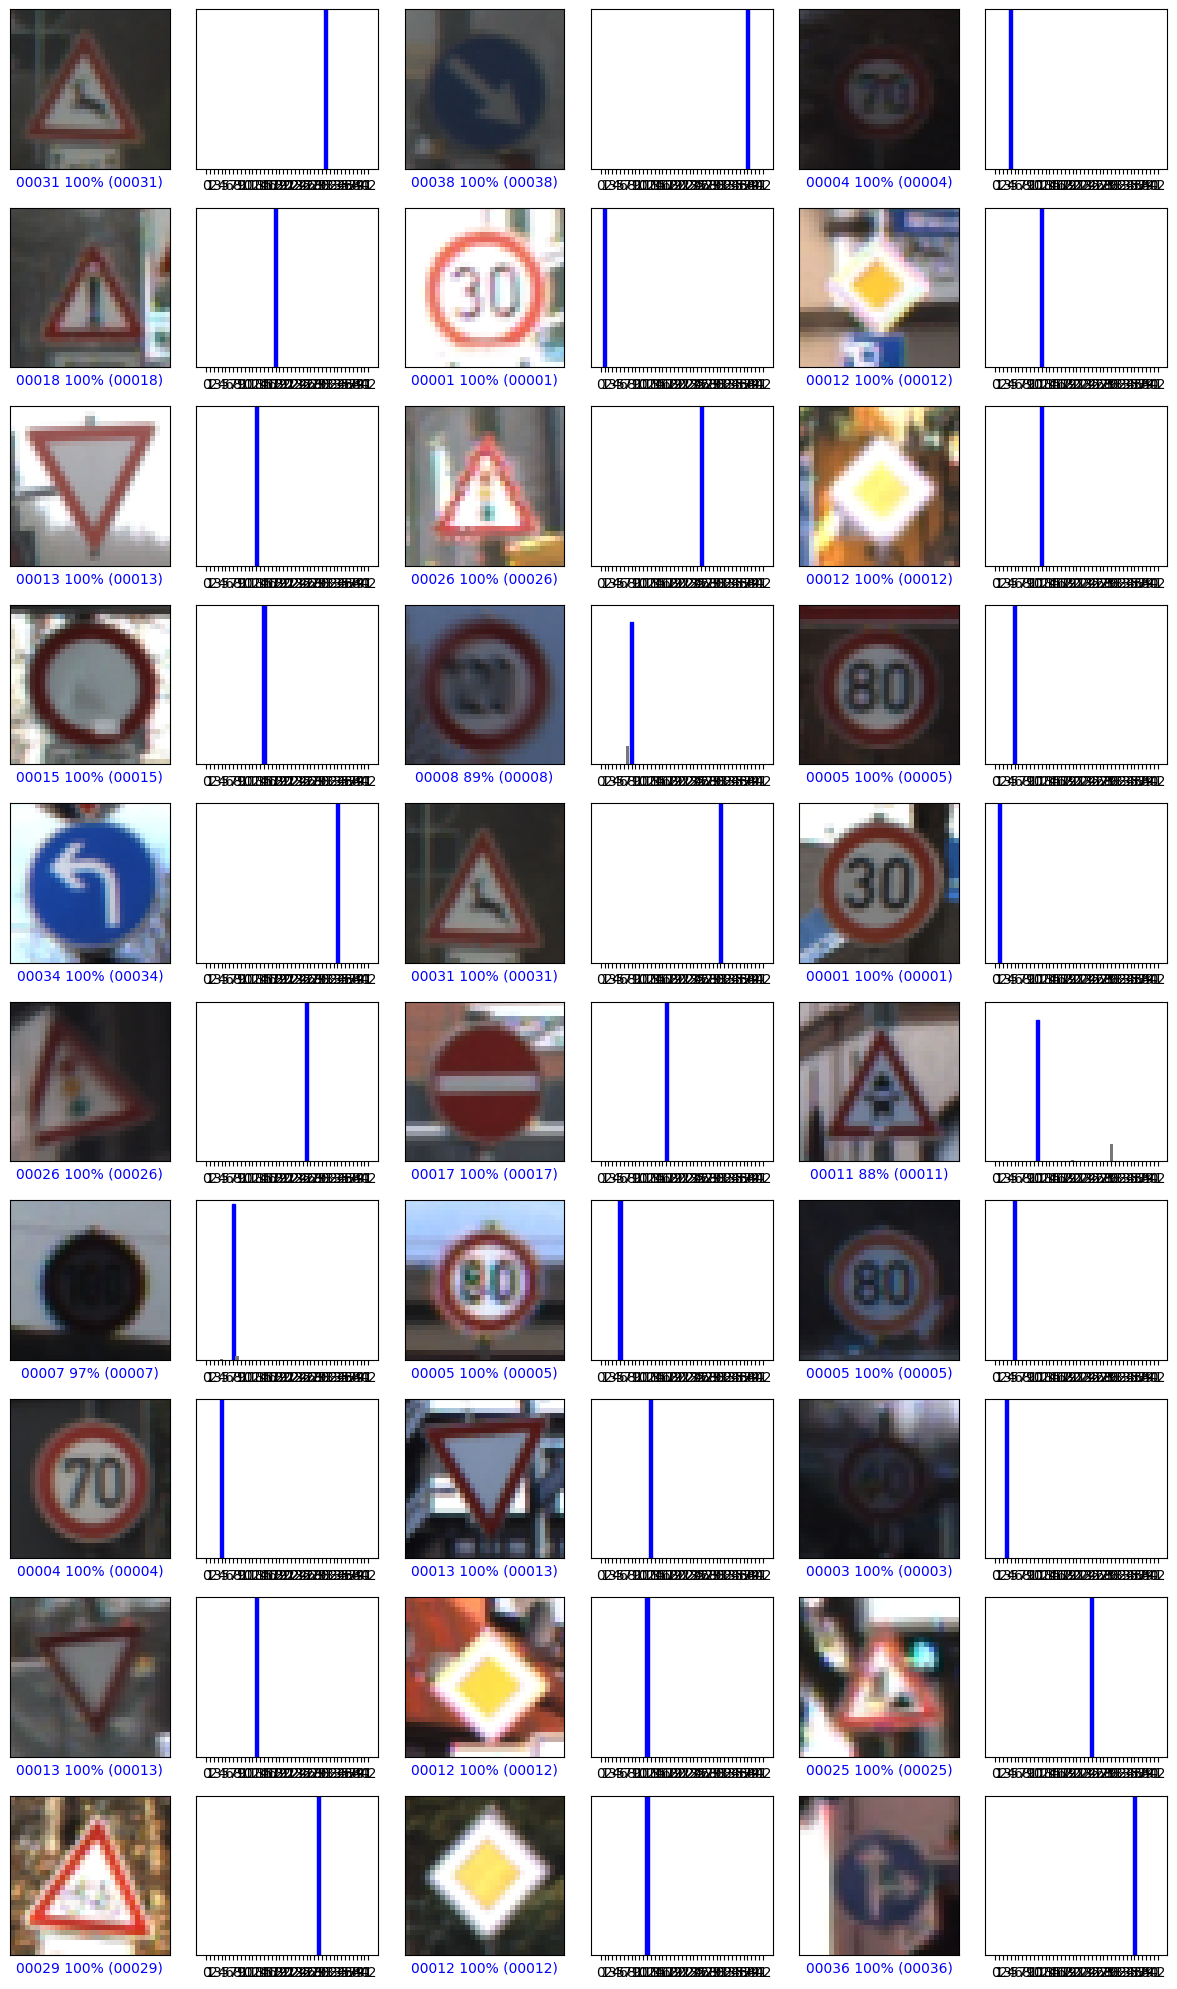

In [47]:
images, targets = next(iter(test_loader))
logits = model_I_transforms(images.to(DEVICE))

predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
vcpi_util.plot_predictions(images, predictions, targets, train_data.classes, 10, 3)

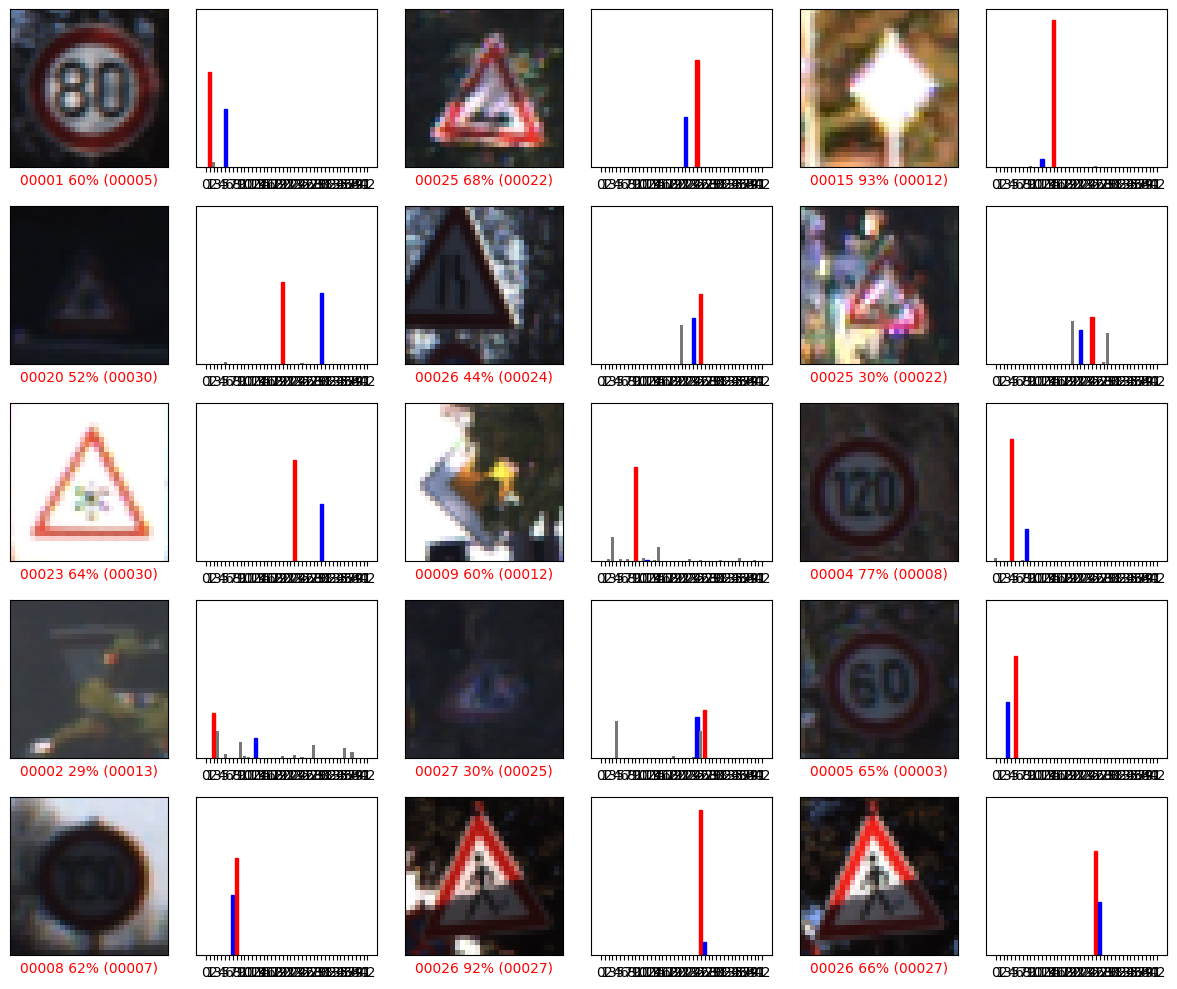

In [48]:
show_bad_preds(model_I_transforms, test_loader, train_data.classes, DEVICE, BATCH_SIZE, train_data)

---

# Modelo com os dados originais e transformações adicionais

Para estas transformações utilizaremos as acima com a adição do RandomErasing que "apaga" pedaços aleatórios das imagens visando previnir o "overfitting" do modelo

---

In [49]:
transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.2,p=1.0),
        v2.RandomAffine(degrees=3, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
        v2.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2),
        v2.RandomEqualize(p=0.5),
        v2.RandomErasing(p=1, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random')
])

base_transform = v2.Compose([
        v2.ToImage(),
        v2.Resize((IMG_SIZE, IMG_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
])


test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE, shuffle=True)

rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
train_set, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3])

train_loader = torch.utils.data.DataLoader(TransfDataset(train_set,transform), batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(TransfDataset(val_set,base_transform), batch_size = BATCH_SIZE)

Vamos ver algumas imagens do dataset de treino

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

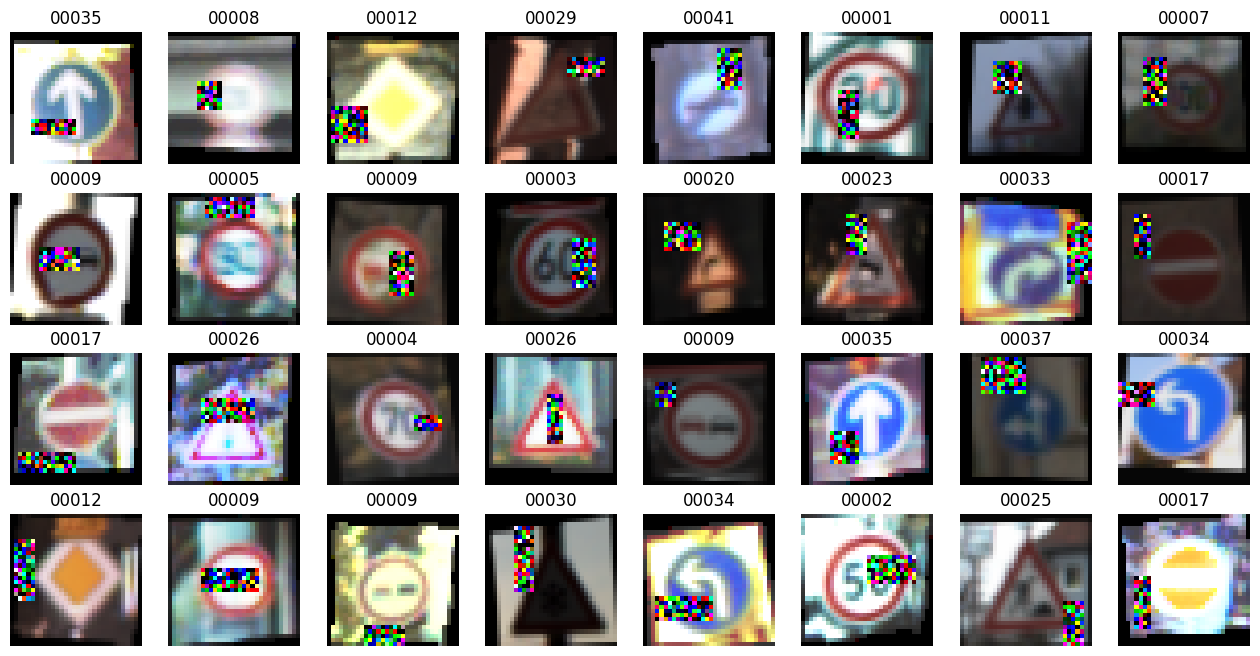

<Figure size 640x480 with 0 Axes>

In [50]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

Vamos ver algumas imagens do dataset de validação

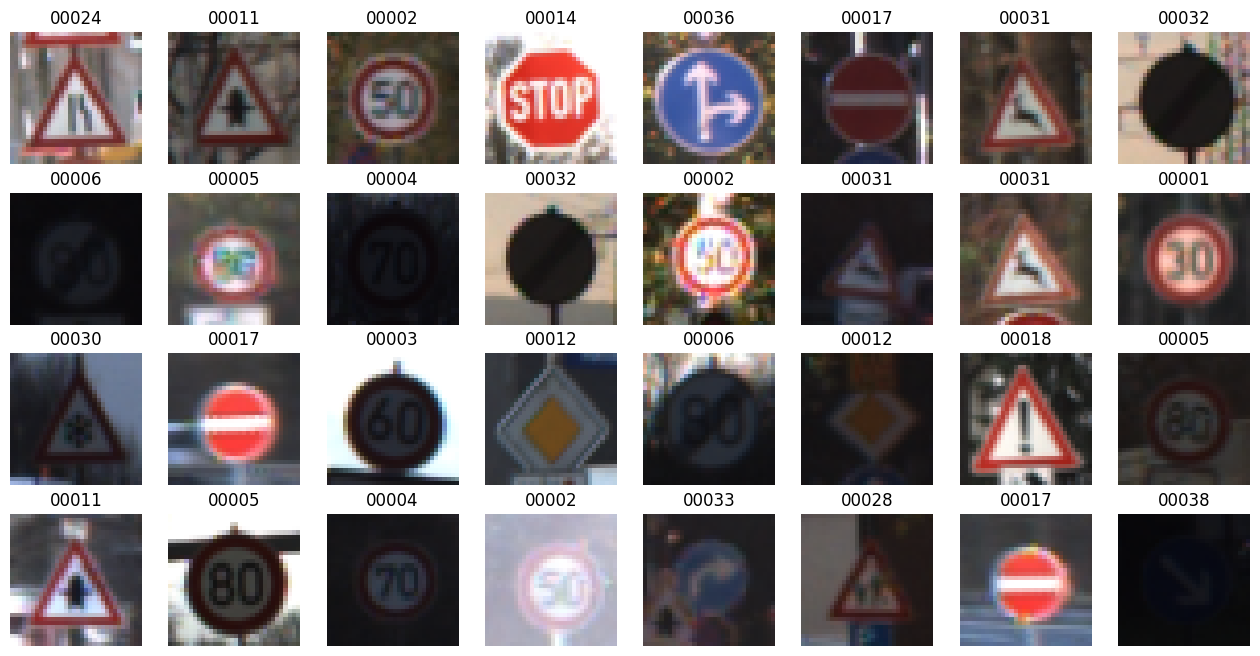

<Figure size 640x480 with 0 Axes>

In [51]:
images, targets = next(iter(val_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

Vamos ver algumas imagens do dataset de teste

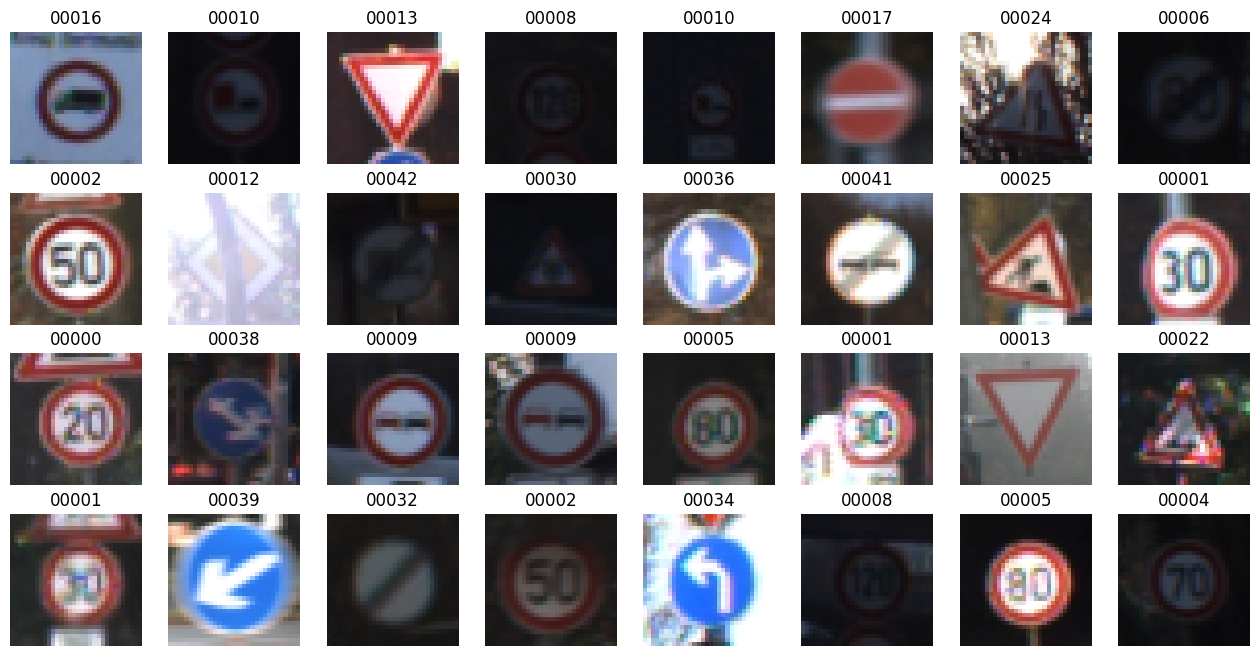

<Figure size 640x480 with 0 Axes>

In [52]:
images, targets = next(iter(test_loader))
vcpi_util.show_images(4,8,images,targets,test_set.classes)

In [53]:
model_I_transforms_RE = Conv(len(rtrain_set.classes))
model_I_transforms_RE.to(DEVICE)

optimizer = torch.optim.Adam(model_I_transforms_RE.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9)

In [54]:
save_prefix="model_I_transforms_re"
path_name="model_I_transforms_re"
if not os.path.exists(f"models/{path_name}"):
    history_I_transforms_RE = train(DEVICE,
                                    model_I_transforms_RE, 
                                    train_loader, 
                                    val_loader, 
                                    EPOCHS, 
                                    loss_fn, 
                                    optimizer, 
                                    scheduler, 
                                    early_stopping, 
                                    save_prefix, 
                                    path_name)
    
model_I_transforms_RE.load_state_dict(torch.load(f"models/{path_name}/{save_prefix}_best.pt")["model"])
history_I_transforms_RE = torch.load(f"models/{path_name}/{save_prefix}_best.pt")["history"]

In [55]:
#Vamos avaliar o modelo 
best_train_transforms_re = np.asarray(history_I_transforms_RE['accuracy']).argmax()
best_val_transforms_re = np.asarray(history_I_transforms_RE['val_acc']).argmax()
print(f"Best train accuracy: {history_I_transforms_RE['accuracy'][best_train_transforms_re]}")
print(f"Best val accuracy: {history_I_transforms_RE['val_acc'][best_val_transforms_re]}")

Best train accuracy: 99.78504180908203
Best val accuracy: 99.85546875


In [56]:
eval_I_transforms_re = evaluate(model_I_transforms_RE, test_loader, DEVICE)
print(eval_I_transforms_re)

0.992794930934906


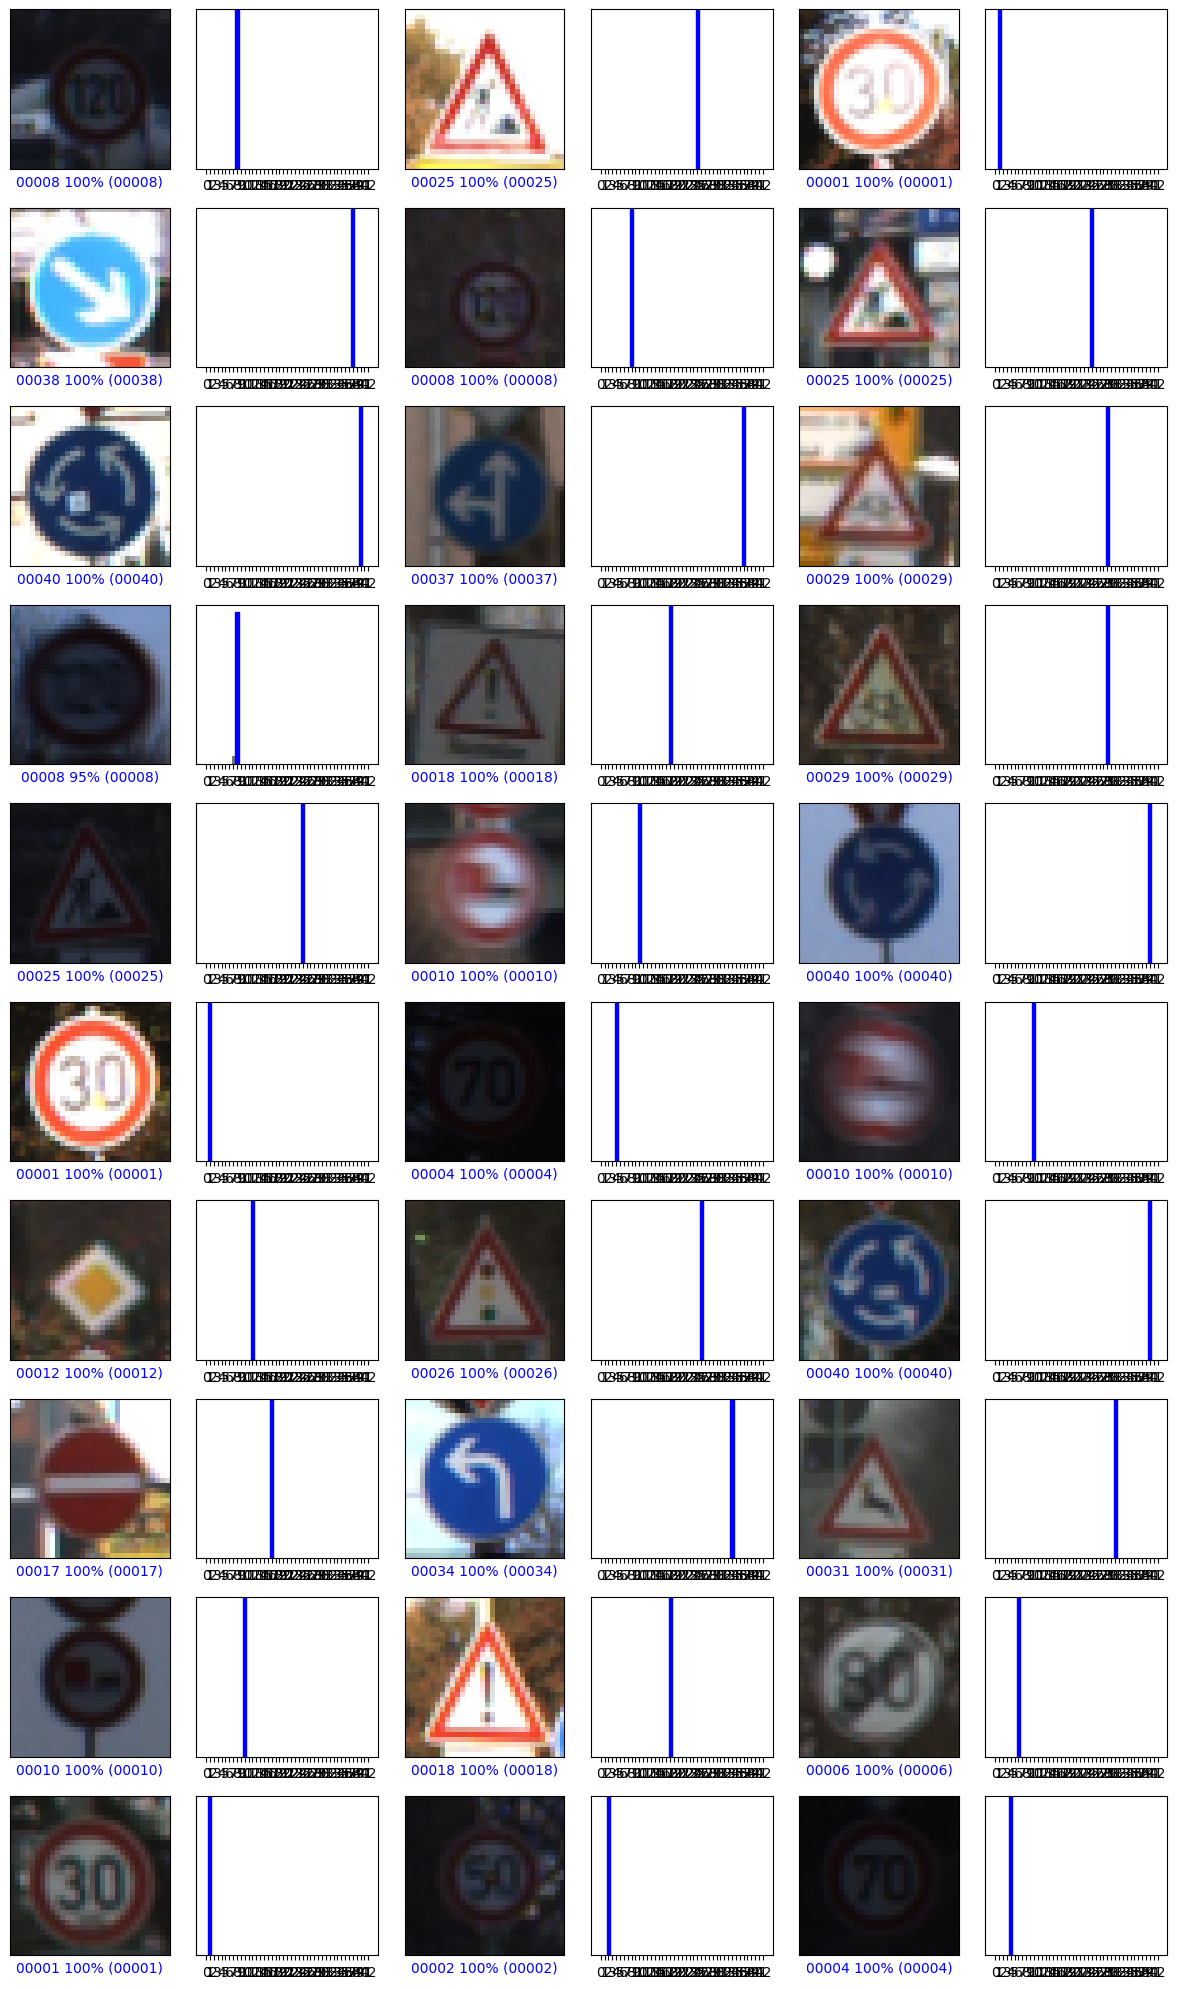

In [57]:
images, targets = next(iter(test_loader))
logits = model_I_transforms_RE(images.to(DEVICE))

predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
vcpi_util.plot_predictions(images, predictions, targets, train_data.classes, 10, 3)

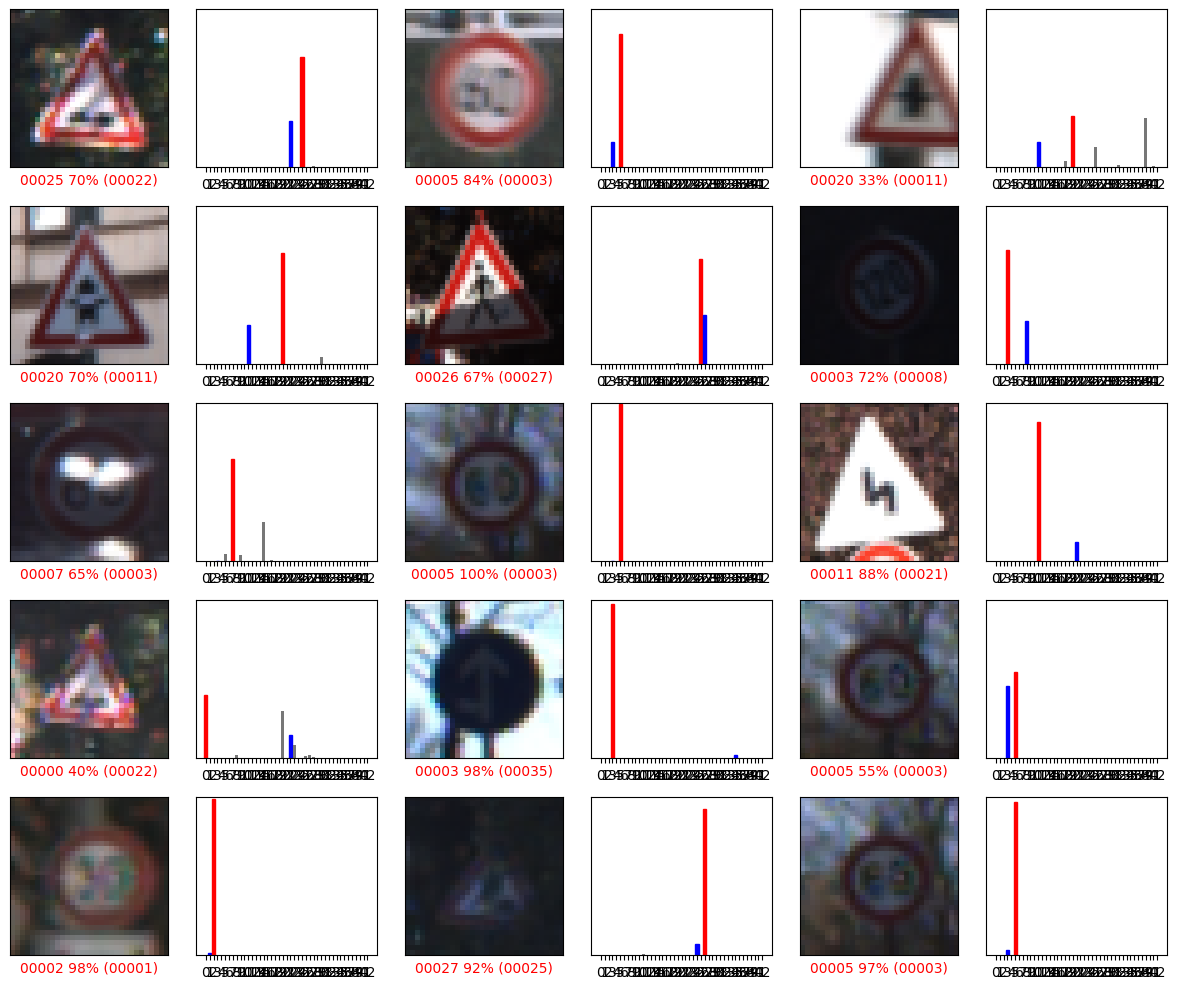

In [58]:
show_bad_preds(model_I_transforms_RE, test_loader, train_data.classes, DEVICE, BATCH_SIZE, train_data)

# Vamos agora comparar os resultados para todas as abordagens acima, com os dados originais e com a aplicação das transformações aos mesmos


Text(0.5, 1.0, 'Model trained with transformations+RandomErasing')

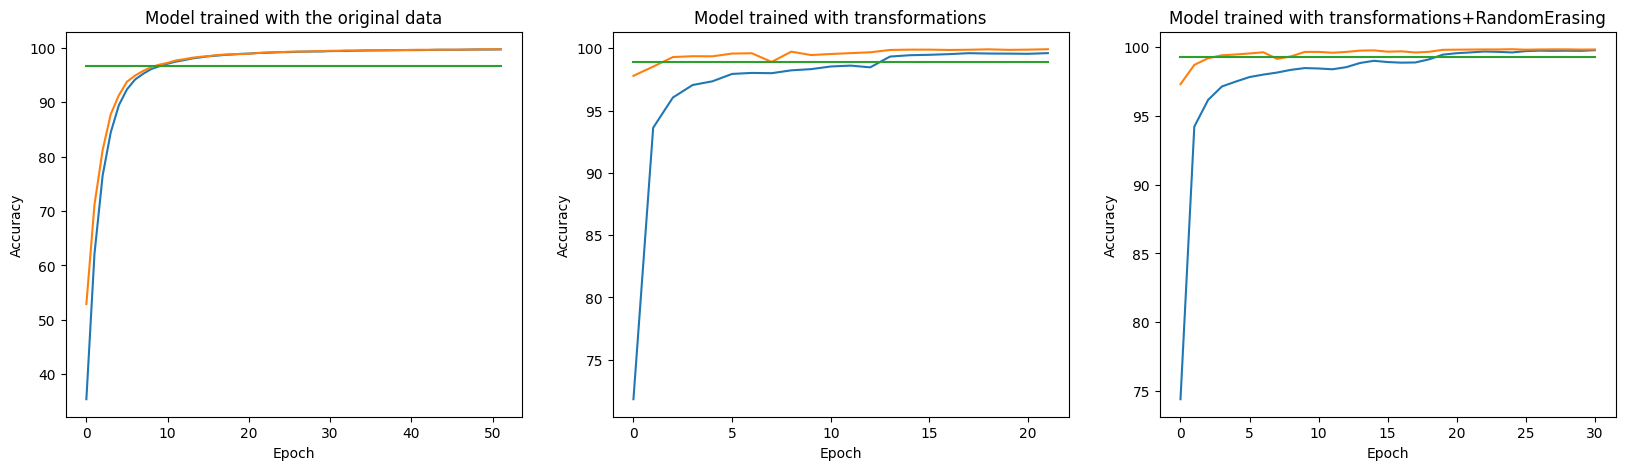

In [63]:
#Lets compare the test accuracy accuracy from the evaluation process for the two models and it history through a grah plot

#Lets create a plot with two sides, one for each approach
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].plot(history_I['accuracy'], label='Train')
axs[0].plot(history_I['val_acc'], label='Validation')
axs[0].plot([eval_I*100 for _ in range(len(history_I['accuracy']))], label='Test')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Model trained with the original data')


axs[1].plot(history_I_transforms['accuracy'], label='Train')
axs[1].plot(history_I_transforms['val_acc'], label='Validation')
axs[1].plot([eval_I_transforms*100 for _ in range(len(history_I_transforms['accuracy']))], label='Test')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Model trained with transformations')


axs[2].plot(history_I_transforms_RE['accuracy'], label='Train')
axs[2].plot(history_I_transforms_RE['val_acc'], label='Validation')
axs[2].plot([eval_I_transforms_re*100 for _ in range(len(history_I_transforms_RE['accuracy']))], label='Test')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Model trained with transformations+RandomErasing')

---

# Modelo com dados gerados sintéticamente

---

In [61]:
transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.2,p=1.0),
        v2.RandomAffine(degrees=3, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
        v2.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2),
        v2.RandomEqualize(p=0.5),
        v2.RandomErasing(p=1, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random')
])


test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
_, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3])

train_data = torchvision.datasets.ImageFolder(root=PATH_TRAINING_ENHANCED, transform = base_transform)
train_loader = torch.utils.data.DataLoader(TransfDataset(train_data, transform), batch_size = BATCH_SIZE)

val_loader = torch.utils.data.DataLoader(TransfDataset(val_set,base_transform), batch_size = BATCH_SIZE)

Vamos ver algumas imagens do dataset de treino

In [ ]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

Vamos ver algumas imagens do dataset de validação

In [ ]:
images, targets = next(iter(val_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

Vamos ver algumas imagens do dataset de teste

In [ ]:
images, targets = next(iter(test_loader))
vcpi_util.show_images(4,8,images,targets,test_set.classes)

In [ ]:
model_I_transforms_RE = Conv(len(rtrain_set.classes))
model_I_transforms_RE.to(DEVICE)

optimizer = torch.optim.Adam(model_I_transforms_RE.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9)

In [ ]:
save_prefix="model_I_transforms_RE"
path_name="model_I_transforms_RE"
if not os.path.exists(f"models/{path_name}"):
    history_I_transforms_RE = train(DEVICE,
                                    model_I_transforms_RE, 
                                    train_loader, 
                                    val_loader, 
                                    EPOCHS, 
                                    loss_fn, 
                                    optimizer, 
                                    scheduler, 
                                    early_stopping, 
                                    save_prefix, 
                                    path_name)
    
model_I_transforms_RE.load_state_dict(torch.load(f"models/{path_name}/{save_prefix}_best.pt")["model"])
history_I_transforms_RE = torch.load(f"models/{path_name}/{save_prefix}_best.pt")["history"]

In [ ]:
#Vamos avaliar o modelo 
best_train_transforms_re = np.asarray(history_I_transforms_RE['accuracy']).argmax()
best_val_transforms_re = np.asarray(history_I_transforms_RE['val_acc']).argmax()
print(f"Best train accuracy: {history_I_transforms_RE['accuracy'][best_train_transforms_re]}")
print(f"Best val accuracy: {history_I_transforms_RE['val_acc'][best_val_transforms_re]}")

Best train accuracy: 99.9011001586914
Best val accuracy: 99.99999237060547


In [ ]:
eval_I_transforms_re = evaluate(model_I_transforms_RE, test_loader, DEVICE)
print(eval_I_transforms_re)

0.8901029229164124


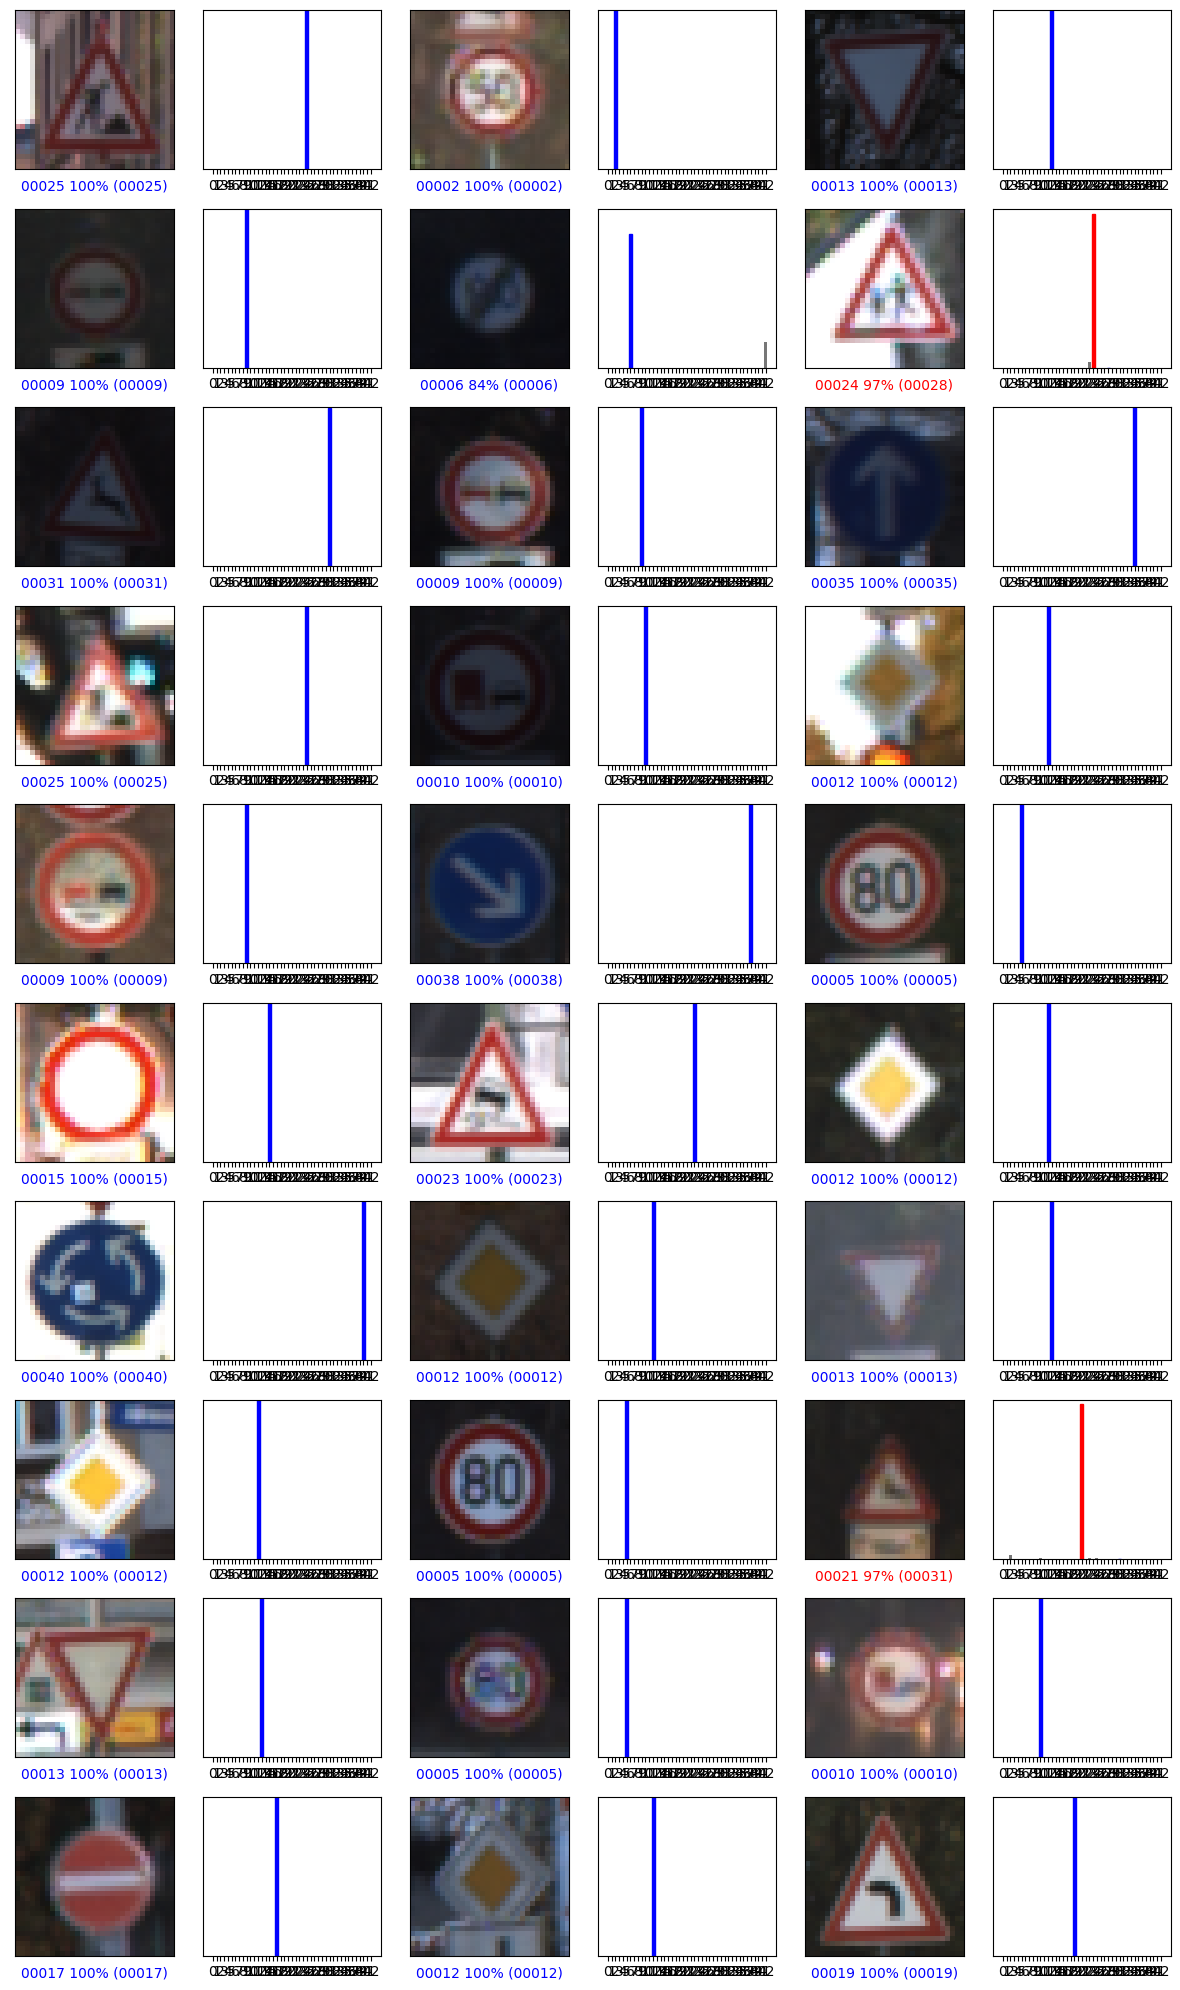

In [ ]:
images, targets = next(iter(test_loader))
logits = model_I_transforms_RE(images.to(DEVICE))

predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
vcpi_util.plot_predictions(images, predictions, targets, train_data.classes, 10, 3)

#vcpi_util.show_bad_preds(model_I_augmented, test_loader, DEVICE, train_data_original.classes)

---

In [32]:
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


In [33]:
modelImagenet = torchvision.models.vgg16(weights = torchvision.models.VGG16_Weights.IMAGENET1K_V1)
modelVGG = torchvision.models.vgg16()
#Vamos utilizar a mobilenet que é uma rede mais simples/rápida para uma possível utilização em carros por exemplo
modelMobileNet = torchvision.models.mobilenet_v2()
modelEficientNet = torchvision.models.efficientnet_b0(weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)


In [16]:
print(torchinfo.summary(modelImagenet, (BATCH_SIZE,3, IMG_SIZE, IMG_SIZE)))
print(modelImagenet)

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [64, 1000]                --
├─Sequential: 1-1                        [64, 512, 1, 1]           --
│    └─Conv2d: 2-1                       [64, 64, 32, 32]          1,792
│    └─ReLU: 2-2                         [64, 64, 32, 32]          --
│    └─Conv2d: 2-3                       [64, 64, 32, 32]          36,928
│    └─ReLU: 2-4                         [64, 64, 32, 32]          --
│    └─MaxPool2d: 2-5                    [64, 64, 16, 16]          --
│    └─Conv2d: 2-6                       [64, 128, 16, 16]         73,856
│    └─ReLU: 2-7                         [64, 128, 16, 16]         --
│    └─Conv2d: 2-8                       [64, 128, 16, 16]         147,584
│    └─ReLU: 2-9                         [64, 128, 16, 16]         --
│    └─MaxPool2d: 2-10                   [64, 128, 8, 8]           --
│    └─Conv2d: 2-11                      [64, 256, 8, 8]           29

In [17]:
print(torchinfo.summary(modelVGG, (BATCH_SIZE,3, IMG_SIZE, IMG_SIZE)))
print(modelVGG)

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [64, 1000]                --
├─Sequential: 1-1                        [64, 512, 1, 1]           --
│    └─Conv2d: 2-1                       [64, 64, 32, 32]          1,792
│    └─ReLU: 2-2                         [64, 64, 32, 32]          --
│    └─Conv2d: 2-3                       [64, 64, 32, 32]          36,928
│    └─ReLU: 2-4                         [64, 64, 32, 32]          --
│    └─MaxPool2d: 2-5                    [64, 64, 16, 16]          --
│    └─Conv2d: 2-6                       [64, 128, 16, 16]         73,856
│    └─ReLU: 2-7                         [64, 128, 16, 16]         --
│    └─Conv2d: 2-8                       [64, 128, 16, 16]         147,584
│    └─ReLU: 2-9                         [64, 128, 16, 16]         --
│    └─MaxPool2d: 2-10                   [64, 128, 8, 8]           --
│    └─Conv2d: 2-11                      [64, 256, 8, 8]           29

In [18]:
print(torchinfo.summary(modelMobileNet, (BATCH_SIZE,3, IMG_SIZE, IMG_SIZE)))
print(modelMobileNet)

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [64, 1000]                --
├─Sequential: 1-1                                  [64, 1280, 1, 1]          --
│    └─Conv2dNormActivation: 2-1                   [64, 32, 16, 16]          --
│    │    └─Conv2d: 3-1                            [64, 32, 16, 16]          864
│    │    └─BatchNorm2d: 3-2                       [64, 32, 16, 16]          64
│    │    └─ReLU6: 3-3                             [64, 32, 16, 16]          --
│    └─InvertedResidual: 2-2                       [64, 16, 16, 16]          --
│    │    └─Sequential: 3-4                        [64, 16, 16, 16]          896
│    └─InvertedResidual: 2-3                       [64, 24, 8, 8]            --
│    │    └─Sequential: 3-5                        [64, 24, 8, 8]            5,136
│    └─InvertedResidual: 2-4                       [64, 24, 8, 8]            --
│    │    └─Sequential: 3-6   

In [23]:
print(torchinfo.summary(modelEficientNet, (BATCH_SIZE,3, IMG_SIZE, IMG_SIZE)))
print(modelEficientNet)

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [64, 1000]                --
├─Sequential: 1-1                                       [64, 1280, 1, 1]          --
│    └─Conv2dNormActivation: 2-1                        [64, 32, 16, 16]          --
│    │    └─Conv2d: 3-1                                 [64, 32, 16, 16]          (864)
│    │    └─BatchNorm2d: 3-2                            [64, 32, 16, 16]          (64)
│    │    └─SiLU: 3-3                                   [64, 32, 16, 16]          --
│    └─Sequential: 2-2                                  [64, 16, 16, 16]          --
│    │    └─MBConv: 3-4                                 [64, 16, 16, 16]          (1,448)
│    └─Sequential: 2-3                                  [64, 24, 8, 8]            --
│    │    └─MBConv: 3-5                                 [64, 24, 8, 8]            (6,004)
│    │    └─MBConv: 3-6                      

In [34]:
#Vamos congelar todos os parâmetros de cada rede
for param in modelImagenet.parameters():
    param.requires_grad = False

for param in modelVGG.parameters():
    param.requires_grad = False

for param in modelMobileNet.parameters():
    param.requires_grad = False

for param in modelEficientNet.parameters():
    param.requires_grad = False

nInputsImagenet = modelImagenet.classifier[0].in_features
nInputsVGG = modelVGG.classifier[0].in_features
nInputsEfficientNet = modelEficientNet.classifier[1].in_features


#Vamos adicionar um classificador ao final de cada rede
modelImagenet.classifier = torch.nn.Sequential(
    torch.nn.Linear(nInputsImagenet, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, len(train_data.classes))
)

modelEficientNet.classifier = torch.nn.Sequential(
    torch.nn.Linear(1024, len(train_data.classes))
)


#modelMobileNet.classifier = torch.nn.Sequential(
#    torch.nn.Linear(nInputsMobileNet, 1024),
#    torch.nn.ReLU(),
#    torch.nn.Linear(1024, len(train_data_original.classes))
#)

#eficientNet.classifier = torch.nn.Sequential(
#    torch.nn.Linear(nInputsEfficientNet, 1024),
#    torch.nn.ReLU(),
#    torch.nn.Linear(1024, len(train_data_original.classes))
#)

---

Vamos experimentar com o modelo imagenet

---

In [35]:
transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.2,p=1.0),
        v2.RandomAffine(degrees=3, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
        v2.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2),
        v2.RandomEqualize(p=0.5),
        v2.RandomErasing(p=1, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random')
])


test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
train_set, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3])

train_loader = torch.utils.data.DataLoader(TransfDataset(train_set,transform), batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(TransfDataset(val_set,base_transform), batch_size = BATCH_SIZE)

In [36]:
modelImagenet.to(DEVICE)

optimizer = torch.optim.Adam(modelImagenet.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9)

loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
if not os.path.exists(f"models/modelImagenet"):
    history_modelImagenet = train(DEVICE,
                                    modelImagenet, 
                                    train_loader, 
                                    val_loader, 
                                    EPOCHS, 
                                    loss_fn, 
                                    optimizer, 
                                    scheduler, 
                                    early_stopping, 
                                    "modelImagenet", 
                                    "modelImagenet")
modelImagenet.load_state_dict(torch.load(f"models/modelImagenet/modelImagenet_best.pt")["model"])
history_modelImagenet = torch.load(f"models/modelImagenet/modelImagenet_best.pt")["history"]

In [29]:
eval_modelImagenet = evaluate(modelImagenet, test_loader, DEVICE)
print(eval_modelImagenet)

0.258511483669281


In [30]:
#Vamos avaliar o modelo
best_train_ImageNet = np.asarray(history_modelImagenet['accuracy']).argmax()
best_val_ImageNet = np.asarray(history_modelImagenet['val_acc']).argmax()
print(f"Best train accuracy: {history_modelImagenet['accuracy'][best_train_ImageNet]}")
print(f"Best val accuracy: {history_modelImagenet['val_acc'][best_val_ImageNet]}")


Best train accuracy: 22.352169036865234
Best val accuracy: 27.503826141357422


---

Vamos experimentar com o modelo VGG16

---

In [ ]:
modelImagenetAugmented = modelImagenet
modelImagenetAugmented.to(DEVICE)
#Vamos agora testar o modelo com data augmentation
optimizer_ImageNetAugmented = torch.optim.Adam(modelImagenetAugmented.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ImageNetAugmented, mode='min', factor=0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()
early_stopping = Early_Stopping(9)

#Vamos treinar o modelo
historyImageNetAugmented = train(DEVICE, modelImagenetAugmented, train_augmented, train_augmented_loader, val_sub, val_sub_loader, EPOCHS, loss_fn, optimizer_II, scheduler, early_stopping, "model_ImageNet_augmented", "model_ImageNet_augmented")
torch.save(modelImagenet.state_dict(), f"models/model_ImageNet_augmented/model_ImageNet_augmented_best.pth")

In [ ]:
eval_ImageNet_augmented = evaluate(modelImagenetAugmented, test_loader, DEVICE)
print(eval_ImageNet_augmented)

In [ ]:
#Vamos avaliar o modelo
best_train_ImageNet_augmented = np.asarray(historyImageNetAugmented['accuracy']).argmax()
best_val_ImageNet_augmented = np.asarray(historyImageNetAugmented['val_accuracy']).argmax()
print(f"Best train accuracy: {historyImageNet['accuracy'][best_train_ImageNet_augmented]}")
print(f"Best val accuracy: {historyImageNet['val_accuracy'][best_val_ImageNet_augmented]}")

# Fase II


Utilização de ensembles para melhorar os resultados
Até então os nossos melhores resultados foram: Fazer tabela

Para esta secção vamos utilizar duas técnicas distintas de forma a tentarmos atingir os melhores resultados, vamos utilizar soft voting e hard voting. 

Hard voting consiste em realizar a média dos votos e o resultado mais votado será o eleito.

Já no soft voting, utiliza as probabilidades previstas para cada classe para cada modelo e realiza a média entre as mesmas para retornar a melhor precisão final

# Vamos começar por implementar o hard voting

In [85]:
train_data = torchvision.datasets.ImageFolder(PATH_TRAINING_SET, transform=base_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

import collections

def get_labels_logits_and_preds(models, test_loader, device):

    with torch.no_grad():
        logits = [[] for _ in range(len(models))]
        labels = []

        for images, labs in test_loader:

            images = images.to(device)
            labels.extend(labs)
            
            for i in range(len(models)):
                logits[i].extend(models[i](images).cpu())


    return labels, logits

def get_stats(labels, class_preds, class_logits):

    all_correct = 0
    all_incorrect = 0
    maj_vote = 0
    maj_wrong = 0
    tie = 0
    count = 0

    for k in range(len(labels)):

        counter = collections.Counter(class_preds[k])
        if len(counter) == 1:
            if counter.most_common(1)[0][0] == labels[k]:
                all_correct += 1
            else:
                all_incorrect += 1
        else:
            aux = counter.most_common(2)
            if aux[0][1] > aux[1][1] and aux[0][0] == labels[k]:
                maj_vote += 1
            if aux[0][1] > aux[1][1] and aux[0][0] != labels[k]:
                maj_wrong += 1
            elif aux[0][1] == aux[1][1]:
                tie += 1

        count += 1 
        
    return [count, all_correct, all_incorrect, maj_vote, tie, maj_wrong]

def get_class_from_sum_of_logits(logits, numModels):

    sum_logits = []

    for i in range(len(logits[0])):

        log = logits[0][i]
        for m in range(1, numModels):
            log = np.add(log, logits[m][i])
        sum_logits.append(np.argmax(log))
    return(sum_logits)
    

def hard_voting(device, test_loader, train_data, selectedModels = os.listdir("models")):
    models = []
    acc = []
    for model in selectedModels:
        if os.path.isdir(f"models/{model}"):
            #Lets get the best model from the folder, the best model terminates with _best.pt
            bestModel = [f for f in os.listdir(f"models/{model}") if f.endswith("_best.pt")]

            for m in bestModel:
            # #Substituir o 8 pelo numero de output features
                reload = Conv(len(train_data.classes))
                reload.load_state_dict(torch.load(f"models/{model}/{m}")["model"])
                reload.to(device)
                models.append(reload)
                evalRes = evaluate(reload, test_loader, device)
                print(f"Model {m} accuracy: {evalRes}")
                acc.append(evalRes)
        

    labels, logits = get_labels_logits_and_preds(models, test_loader, device)
    preds = [[] for _ in range(len(labels)) ]

    for index in range(len(labels)):
        preds[index] = [np.argmax(logits[m][index].cpu().numpy()) for m in range(len(models))]
    
    class_logits = get_class_from_sum_of_logits(logits, len(models))

    res = get_stats(labels, preds, class_logits)
    print(f"No. of models used for voting: {len(models)}")
    print("---------------------------------")
    print('total: ', res[0])
    print('All correct: ', res[1])
    print('All incorrect: ', res[2])
    print('Majority correct: ', res[3])
    print('Tie Vote: ', res[4])
    print('Majority Wrong: ', res[5])
    print('Percentage right: ', (res[1]+res[3])/res[0])
    
hard_voting(device=DEVICE, test_loader=test_loader, train_data = train_data, selectedModels=["model_I_noaugmentation", "model_I_transforms", "model_I_transforms_re"])

Model model_I_noaugmentation_best.pt accuracy: 0.967695951461792
Model model_I_base_best.pt accuracy: 0.9795724749565125
Model model_I_transforms_best.pt accuracy: 0.9888361096382141
Model model_I_transforms_re_best.pt accuracy: 0.992794930934906
Model model12_9926_best.pt accuracy: 0.9924782514572144
No. of models used for voting: 5
---------------------------------
total:  12630
All correct:  12012
All incorrect:  8
Majority correct:  551
Tie Vote:  19
Majority Wrong:  40
Percentage right:  0.9946951702296121


Podemos ver que face aos resultados dos modelos independentemente, temos uma accuracy muito superior

# Soft Voting

In [87]:
import torch
import numpy as np
import os
import collections
from torch.nn.functional import softmax

def get_labels_logits_and_preds(models, test_loader, device):
    with torch.no_grad():
        logits = [[] for _ in range(len(models))]
        labels = []

        for images, labs in test_loader:
            images = images.to(device)
            labels.extend(labs)

            for i in range(len(models)):
                logits[i].extend(models[i](images).cpu())

    return labels, logits

def get_stats(labels, class_preds, class_logits):
    all_correct = 0
    all_incorrect = 0
    maj_vote = 0
    maj_wrong = 0
    tie = 0
    count = 0

    for k in range(len(labels)):
        counter = collections.Counter(class_preds[k])
        if len(counter) == 1:
            if counter.most_common(1)[0][0] == labels[k]:
                all_correct += 1
            else:
                all_incorrect += 1
        else:
            aux = counter.most_common(2)
            if aux[0][1] > aux[1][1] and aux[0][0] == labels[k]:
                maj_vote += 1
            if aux[0][1] > aux[1][1] and aux[0][0] != labels[k]:
                maj_wrong += 1
            elif aux[0][1] == aux[1][1]:
                tie += 1

        count += 1 
        
    # Calculate the accuracy based on the final predictions
    correct_predictions = sum([1 for i in range(len(labels)) if class_logits[i] == labels[i]])
    accuracy = correct_predictions / len(labels)

    return {
        'total': count,
        'all_correct': all_correct,
        'all_incorrect': all_incorrect,
        'majority_correct': maj_vote,
        'tie_vote': tie,
        'majority_wrong': maj_wrong,
        'accuracy': accuracy
    }

def get_class_from_weighted_avg_logits(logits, weights):
    weighted_avg_logits = []

    for i in range(len(logits[0])):
        summed_logit = weights[0] * logits[0][i]
        for m in range(1, len(logits)):
            summed_logit = np.add(summed_logit, weights[m] * logits[m][i])
        avg_logit = summed_logit / sum(weights)
        weighted_avg_logits.append(np.argmax(avg_logit))
    return weighted_avg_logits


def soft_voting(device, test_loader, train_data, selected_models=None):
    if selected_models is None:
        selected_models = os.listdir("models")

    models = []
    accuracies = []
    for model in selected_models:
        if os.path.isdir(f"models/{model}"):
            best_model_files = [f for f in os.listdir(f"models/{model}") if f.endswith("_best.pt")]

            for m in best_model_files:
                # Load model and set to evaluation mode
                reload = Conv(len(train_data.classes))  # Replace 'Conv' with your actual model class
                reload.load_state_dict(torch.load(f"models/{model}/{m}")["model"])
                reload.to(device)
                reload.eval()
                models.append(reload)

                # Evaluate accuracy of the model
                accuracy = evaluate(reload, test_loader, device)
                accuracies.append(accuracy)
                print(f"Model {m} accuracy: {accuracy}")

    if not models:
        print("No models found for voting.")
        return

    labels, logits = get_labels_logits_and_preds(models, test_loader, device)
    
    prob_logits = [[softmax(logit.clone().detach(), dim=-1).numpy() for logit in model_logits] for model_logits in logits]
    
    
    preds = [[np.argmax(prob_logit) for prob_logit in model_logits] for model_logits in prob_logits]
    
    # Transpose preds to group predictions for each sample
    preds = list(map(list, zip(*preds)))
    
    # Calculate class predictions based on weighted averaged probabilities
    class_logits = get_class_from_weighted_avg_logits(prob_logits, accuracies)

    # Calculate statistics
    stats = get_stats(labels, preds, class_logits)
    
    print(f"No. of models used for voting: {len(models)}")
    print("---------------------------------")
    print('Total samples:', stats['total'])
    print('All correct:', stats['all_correct'])
    print('All incorrect:', stats['all_incorrect'])
    print('Majority correct:', stats['majority_correct'])
    print('Tie vote:', stats['tie_vote'])
    print('Majority wrong:', stats['majority_wrong'])
    print('Accuracy:', stats['accuracy'])


soft_voting(device=DEVICE, test_loader=test_loader, train_data=train_data, selected_models=["model_I_noaugmentation", "model_I_transforms", "model_I_transforms_re"])


Model model_I_noaugmentation_best.pt accuracy: 0.967695951461792
Model model_I_base_best.pt accuracy: 0.9795724749565125
Model model_I_transforms_best.pt accuracy: 0.9888361096382141
Model model_I_transforms_re_best.pt accuracy: 0.992794930934906
No. of models used for voting: 4
---------------------------------
Total samples: 12630
All correct: 12038
All incorrect: 10
Majority correct: 452
Tie vote: 87
Majority wrong: 43
Accuracy: 0.995803642121932
